## Load potential modules

In [1]:
#General Imports used across both Models
import sys
import os
import math
import warnings
import matplotlib
import configparser
import pandas as pd
import numpy as np
from tensorflow.keras.optimizers import *
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from matplotlib.legend_handler import HandlerLine2D
#from statsmodels.tsa.seasonal import seasonal_decompose

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

from ecotools.pi_client import pi_client
pi = pi_client(username = r'ad3\dlrueda')

# LSTM Specific Imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
es = EarlyStopping(monitor='val_loss', patience = 3, min_delta= 0.001, mode = 'min', verbose=1)
callbacks_list= [es]

# Random Forest Imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import RandomizedSearchCV

ModuleNotFoundError: No module named 'ecotools'

In [4]:
pip install ecotools

ERROR: Could not find a version that satisfies the requirement ecotools (from versions: none)
ERROR: No matching distribution found for ecotools
Note: you may need to restart the kernel to use updated packages.


In [2]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import HalvingRandomSearchCV
from tune_sklearn import TuneSearchCV
from sklearn.ensemble import ExtraTreesRegressor

## Create functions

In [3]:
def create_standard_multivariable_df(df, point_location = 0, shift = 1, rename_OAT = True, dropna = True):
    #this function creates a standard 50 variable DataFrame
    """
    variables generated:
        - CDD: Cooling Degree Days (OAT-65), 0 where CDD < 0 
        - HDD: Heating Degree Days (65-OAT), 0 where HDD < 0
        - CDD2: (Cooling Degree Days)^2
        - HDD2: (Heating Degree Days)^2
        - MONTH (1-12): 1 on month of data point, 0 on all other months
        - TOD (0-23): 1 on "TIME OF DAY" of data point, 0 on all other times
        - DOW (0-6): 1 on "DAY OF WEEK" of data point, 0 on all other days
        - WEEKEND: 1 if data point falls on weekend, 0 for everything else
        - Shift_N: user defined shift, where N is the amount of lookback
        - Rolling24_mean: generates the rolling 24hr mean 
        - Rolling24_max: takes the maximun value of the rolling 24hr
        - Rolling 24_min: takes the minimum value of the rolling 24hr
    """
    
    if rename_OAT:
        df.rename(columns={'aiTIT4045':'OAT'}, inplace=True)
    #start_col = len(df.columns)
    df["CDD"] = df.OAT - 65.0
    df.loc[df.CDD < 0 , "CDD"] = 0.0
    df["HDD"] = 65.0 - df.OAT
    df.loc[df.HDD < 0, "HDD" ] = 0.0
    df["CDD2"] = df.CDD ** 2
    df["HDD2"] = df.HDD ** 2
    df.OAT = df.OAT.round(0)
    df.CDD = df.CDD.round(0)
    df.HDD = df.HDD.round(0)
    df.CDD2 = df.CDD2.round(0)
    df.HDD2 = df.HDD2.round(0)
    
    month = [str("MONTH_" + str(x+1)) for x in range(12)]
    df["MONTH"] = df.index.month
    df.MONTH = df.MONTH.astype('category')
    month_df = pd.get_dummies(data = df, columns = ["MONTH"])
    month_df = month_df.T.reindex(month).T.fillna(0)
    month_df = month_df.drop(month_df.columns[0], axis = 1)

    tod = [str("TOD_" + str(x)) for x in range(24)]
    df["TOD"] = df.index.hour
    df.TOD = df.TOD.astype('category')
    tod_df = pd.get_dummies(data = df, columns = ["TOD"])
    tod_df = tod_df.T.reindex(tod).T.fillna(0)
    tod_df = tod_df.drop(tod_df.columns[0], axis = 1)

    dow = [str('DOW_' + str(x)) for x in range(7)]
    df["DOW"] = df.index.weekday
    df.DOW = df.DOW.astype('category')
    dow_df = pd.get_dummies(data = df, columns = ["DOW"])
    dow_df = dow_df.T.reindex(dow).T.fillna(0)
    dow_df = dow_df.drop(dow_df.columns[0], axis = 1)

    df["WEEKEND"] = 0
    df.loc[(dow_df.DOW_5 == 1) | (dow_df.DOW_6 == 1), 'WEEKEND'] = 1

    for i in range(shift):
        shift_col = "SHIFT_" + str(i+1)
        df[shift_col] = df.iloc[ : , point_location].shift(i+1)

    # df["Rolling24_mean"] = df.iloc[ : , point_location].rolling("24h").mean()
    # df["Rolling24_max"] = df.iloc[ : , point_location].rolling("24h").max()
    # df["Rolling24_min"] = df.iloc[ : , point_location].rolling("24h").min()

    df = pd.concat([df, month_df, tod_df, dow_df], axis = 1)
    df.drop(['MONTH', 'TOD', 'DOW'], axis = 1, inplace = True)
    if dropna:
        df.dropna(inplace = True)

    del month_df
    del tod_df
    del dow_df
    #print(f'Generated: {len(df.columns) - start_col} columns')
    return df

In [4]:
def model_split_data(X, y, training_percent=0.7, scale = True):
    train_idx = X[ : int(training_percent * len(X))].index
    test_idx = X[int(training_percent * len(X)):].index
    if scale:
        scaler = MinMaxScaler(feature_range=(0,1))
        X = scaler.fit_transform(X)
        y = scaler.fit_transform(np.array(y).reshape((-1,1)))

    X_train, X_test = np.split(X, [int(training_percent * len(X))])
    y_train, y_test = np.split(y, [int(training_percent * len(y))])
    if scale:
        return X_train, X_test, y_train, y_test, scaler, train_idx, test_idx
    else:
        return X_train, X_test, y_train, y_test, train_idx, test_idx

In [5]:
def generate_actual_vs_model_df(model, X, y, scaler, trend, seasonal, index, train_on_residuals = True, use_scaler = True):
    prediction = model.predict(X)
    if use_scaler:
        prediction = scaler.inverse_transform(prediction.reshape(-1,1)).reshape((-1,))
        actual = scaler.inverse_transform(y).reshape((-1,))
    else:
        prediction = np.reshape(prediction,(-1,))
        actual = np.reshape(y, (-1,))
    if train_on_residuals:    
        prediction = prediction + trend + seasonal
        actual = actual + trend + seasonal
    r2 = r2_score(y_true=actual, y_pred=prediction)
    rmse = math.sqrt(mean_squared_error(actual, prediction))
    cvrmse = rmse / np.mean(prediction)
    mae = np.median(actual - prediction)
    result_df = pd.DataFrame({"Actual" : actual, "Modeled" : prediction}, index = index)
    return result_df, r2, rmse, cvrmse, mae

In [6]:
# extra trees regressor with halving random search
def create_etr_model_hrs(df1, X, y, mod_inputs, point_location=0):
    df = df1.copy()
    df.fillna(method = 'ffill', inplace = True)
    df.fillna(method = 'bfill', inplace = True)
#     df = create_standard_multivariable_df(df)

    X_train, X_test, y_train, y_test, scaler , train_idx, test_idx = model_split_data(X,y, mod_inputs['training_percent']) 

    # reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
    X_train = np.nan_to_num(X_train)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))

    train = pd.DataFrame()
    val = pd.DataFrame()
    np.random.seed(mod_inputs['random_seed'])

    # Hyperparameter grid
    #param_grid = {'criterion':['squared_error', 'absolute_error'],  'n_estimators':np.linspace(10, 200).astype(int), 
    #              'random_state':[1], 'min_samples_split': [2, 5, 10],'max_depth': [None] + list(np.linspace(3, 20).astype(int)), 
    #              'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)), 'bootstrap' : [True,False], 
    #              'n_jobs' : [-1]}    
    
    # Hyperparameter grid
    param_grid = {'criterion':['squared_error', 'absolute_error'],                              
                  'n_estimators':[10,100,200], 'random_state':[42], 'min_samples_split': [2, 5, 10],
                 'max_depth': [10,50], 'max_leaf_nodes': [10,100,200]}

    # Estimator for use in random search
    estimator = ExtraTreesRegressor()


    # Create the random search model
    halving_cv = HalvingRandomSearchCV(estimator, param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, n_candidates=10, factor=3, cv = 4)

    # Fit 
    halving_cv.fit(X_train, y_train)
    
    
    
    model = ExtraTreesRegressor(n_estimators = halving_cv.best_params_['n_estimators'], 
                               max_depth = halving_cv.best_params_['max_depth'],
                               max_leaf_nodes = halving_cv.best_params_['max_leaf_nodes'],
                               min_samples_split = halving_cv.best_params_['min_samples_split'],
                               random_state = halving_cv.best_params_['random_state'],
                               criterion = halving_cv.best_params_['criterion'])
    
    
    # fit model
    model = model.fit(X_train, y_train)


#         if kwargs['show_training_plot']:
#             plot_model_training(train, val, epochs, neurons, show_every = show_every)

    #model = history.model

    train_df, train_r2, train_rmse, train_cvrmse, train_mae = generate_actual_vs_model_df(model, 
                                                                                          X_train, y_train, scaler, 
                                                                                          trend = None, seasonal = None, index = train_idx, train_on_residuals = False)
    train_r2 = round(train_r2, 3)
    train_rmse = round(train_rmse, 3)
    train_cvrmse = round(train_cvrmse, 3)
    train_mae = round(train_mae, 3)

    test_df, test_r2, test_rmse, test_cvrmse, test_mae = generate_actual_vs_model_df(model, 
                                                                                     X_test, y_test, scaler, 
                                                                                     trend = None, seasonal = None, index = test_idx, train_on_residuals = False)
    test_r2 = round(test_r2, 3)
    test_rmse = round(test_rmse, 3)
    test_cvrmse = round(test_cvrmse, 3)
    test_mae = round(test_mae, 3) 

    plt.style.use('fivethirtyeight')
    figure(num=None, figsize=(18,5), dpi=80, facecolor='w', edgecolor='k')
    ax = plt.subplot()
    ax.plot(train_df.Actual, label = 'Training', linewidth = 1, color = 'black')
    ax.plot(train_df.Modeled, label = 'Training - Modeled', linewidth = 1, color = 'green', alpha=0.5)
    ax.plot(test_df.Actual, label = 'Test', linewidth = 1, color = 'black')
    ax.plot(test_df.Modeled, label = 'Test - Modeled', linewidth = 1, color = 'blue', alpha=0.5)
    plt.legend(prop={'size': 14})
    train_title = f"Training: Actual vs. Modeled \n R2: {train_r2}  RMSE: {train_rmse}  CVRMSE: {train_cvrmse}  MAE: {train_mae} \n R2 Test: {test_r2}  RMSE Test: {test_rmse}  CVRMSE Test: {test_cvrmse}  MAE Test: {test_mae}"                
    plt.title(train_title, fontsize = 14)
    plt.show()
    
    return halving_cv.best_params_

In [7]:
# random forest regressor with halving random search
def create_rfr_model_hrs(df1, X, y, mod_inputs, point_location=0):
    df = df1.copy()
    df.fillna(method = 'ffill', inplace = True)
    df.fillna(method = 'bfill', inplace = True)
#     df = create_standard_multivariable_df(df)

    X_train, X_test, y_train, y_test, scaler , train_idx, test_idx = model_split_data(X,y, mod_inputs['training_percent']) 

    # reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
    X_train = np.nan_to_num(X_train)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))

    train = pd.DataFrame()
    val = pd.DataFrame()
    np.random.seed(mod_inputs['random_seed'])

    # Hyperparameter grid
    #param_grid = {'criterion':['friedman_mse', 'mse'], 'loss':['ls','lad'],'learning_rate':[0.1,0.01, 0.001, 0.05],                               
    #              'n_estimators':np.linspace(10, 200).astype(int), 'random_state':[42], 'min_samples_split': [2, 5, 10],
    #             'max_depth': [None] + list(np.linspace(3, 20).astype(int)), 'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int))}
    
    
    # Hyperparameter grid
    param_grid = {'criterion':['squared_error', 'absolute_error'], 'n_estimators':[10,100,200], 'random_state':[42], 
                  'min_samples_split': [2, 5, 10], 'max_depth': [10,50], 'max_leaf_nodes': [10,100,200]}

    # Estimator for use in random search
    estimator = RandomForestRegressor()


    # Create the random search model
    halving_cv = HalvingRandomSearchCV(estimator, param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, n_candidates=10, factor=5, cv = 4)
    #halving_cv = TuneSearchCV(estimator, param_grid, n_trials=3)
    
    # Fit 
    halving_cv.fit(X_train, y_train)
    
    
    model = RandomForestRegressor(n_estimators = halving_cv.best_params_['n_estimators'],
                               max_depth = halving_cv.best_params_['max_depth'],
                               max_leaf_nodes = halving_cv.best_params_['max_leaf_nodes'],
                               min_samples_split = halving_cv.best_params_['min_samples_split'],
                               random_state = halving_cv.best_params_['random_state'],
                               criterion = halving_cv.best_params_['criterion'])
    
    
    # fit model
    model = model.fit(X_train, y_train)


#         if kwargs['show_training_plot']:
#             plot_model_training(train, val, epochs, neurons, show_every = show_every)

    #model = history.model

    train_df, train_r2, train_rmse, train_cvrmse, train_mae = generate_actual_vs_model_df(model, 
                                                                                          X_train, y_train, scaler, 
                                                                                          trend = None, seasonal = None, index = train_idx, train_on_residuals = False)
    train_r2 = round(train_r2, 3)
    train_rmse = round(train_rmse, 3)
    train_cvrmse = round(train_cvrmse, 3)
    train_mae = round(train_mae, 3)

    test_df, test_r2, test_rmse, test_cvrmse, test_mae = generate_actual_vs_model_df(model, 
                                                                                     X_test, y_test, scaler, 
                                                                                     trend = None, seasonal = None, index = test_idx, train_on_residuals = False)
    test_r2 = round(test_r2, 3)
    test_rmse = round(test_rmse, 3)
    test_cvrmse = round(test_cvrmse, 3)
    test_mae = round(test_mae, 3) 

    plt.style.use('fivethirtyeight')
    figure(num=None, figsize=(18,5), dpi=80, facecolor='w', edgecolor='k')
    ax = plt.subplot()
    ax.plot(train_df.Actual, label = 'Training', linewidth = 1, color = 'black')
    ax.plot(train_df.Modeled, label = 'Training - Modeled', linewidth = 1, color = 'green', alpha=0.5)
    ax.plot(test_df.Actual, label = 'Test', linewidth = 1, color = 'black')
    ax.plot(test_df.Modeled, label = 'Test - Modeled', linewidth = 1, color = 'blue', alpha=0.5)
    plt.legend(prop={'size': 14})
    train_title = f"Training: Actual vs. Modeled \n R2: {train_r2}  RMSE: {train_rmse}  CVRMSE: {train_cvrmse}  MAE: {train_mae} \n R2 Test: {test_r2}  RMSE Test: {test_rmse}  CVRMSE Test: {test_cvrmse}  MAE Test: {test_mae}"                
    plt.title(train_title, fontsize = 14)
    plt.show()
    
    return halving_cv.best_params_

In [8]:
# gradient boosting regressor with halving random search
def create_gbr_model_hrs(df1, X, y, mod_inputs, point_location=0):
    df = df1.copy()
    df.fillna(method = 'ffill', inplace = True)
    df.fillna(method = 'bfill', inplace = True)
#     df = create_standard_multivariable_df(df)

    X_train, X_test, y_train, y_test, scaler , train_idx, test_idx = model_split_data(X,y, mod_inputs['training_percent']) 

    # reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
    X_train = np.nan_to_num(X_train)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))

    train = pd.DataFrame()
    val = pd.DataFrame()
    np.random.seed(mod_inputs['random_seed'])

    # Hyperparameter grid
    #param_grid = {'criterion':['friedman_mse', 'mse'], 'loss':['ls','lad'],'learning_rate':[0.1,0.01, 0.001, 0.05],                               
    #              'n_estimators':np.linspace(10, 200).astype(int), 'random_state':[42], 'min_samples_split': [2, 5, 10],
    #             'max_depth': [None] + list(np.linspace(3, 20).astype(int)), 'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int))}
    
    
    # Hyperparameter grid
    param_grid = {'criterion':['friedman_mse', 'mse'], 'loss':['ls','lad'],'learning_rate':[0.1,0.01, 0.001],                               
                  'n_estimators':[10,100,200], 'random_state':[42], 'min_samples_split': [2, 5, 10],
                 'max_depth': [10,50], 'max_leaf_nodes': [10,100,200]}

    # Estimator for use in random search
    estimator = GradientBoostingRegressor()


    # Create the random search model
    halving_cv = HalvingRandomSearchCV(estimator, param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, n_candidates=10, factor=5, cv = 4)
    #halving_cv = TuneSearchCV(estimator, param_grid, n_trials=3)
    
    # Fit 
    halving_cv.fit(X_train, y_train)
    
    
    model = GradientBoostingRegressor(n_estimators = halving_cv.best_params_['n_estimators'], 
                               loss = halving_cv.best_params_['loss'],
                               max_depth = halving_cv.best_params_['max_depth'],
                               max_leaf_nodes = halving_cv.best_params_['max_leaf_nodes'],
                               min_samples_split = halving_cv.best_params_['min_samples_split'],
                               random_state = halving_cv.best_params_['random_state'],
                               learning_rate = halving_cv.best_params_['learning_rate'],
                               criterion = halving_cv.best_params_['criterion'])
    
    
    # fit model
    model = model.fit(X_train, y_train)


#         if kwargs['show_training_plot']:
#             plot_model_training(train, val, epochs, neurons, show_every = show_every)

    #model = history.model

    train_df, train_r2, train_rmse, train_cvrmse, train_mae = generate_actual_vs_model_df(model, 
                                                                                          X_train, y_train, scaler, 
                                                                                          trend = None, seasonal = None, index = train_idx, train_on_residuals = False)
    train_r2 = round(train_r2, 3)
    train_rmse = round(train_rmse, 3)
    train_cvrmse = round(train_cvrmse, 3)
    train_mae = round(train_mae, 3)

    test_df, test_r2, test_rmse, test_cvrmse, test_mae = generate_actual_vs_model_df(model, 
                                                                                     X_test, y_test, scaler, 
                                                                                     trend = None, seasonal = None, index = test_idx, train_on_residuals = False)
    test_r2 = round(test_r2, 3)
    test_rmse = round(test_rmse, 3)
    test_cvrmse = round(test_cvrmse, 3)
    test_mae = round(test_mae, 3) 

    plt.style.use('fivethirtyeight')
    figure(num=None, figsize=(18,5), dpi=80, facecolor='w', edgecolor='k')
    ax = plt.subplot()
    ax.plot(train_df.Actual, label = 'Training', linewidth = 1, color = 'black')
    ax.plot(train_df.Modeled, label = 'Training - Modeled', linewidth = 1, color = 'green', alpha=0.5)
    ax.plot(test_df.Actual, label = 'Test', linewidth = 1, color = 'black')
    ax.plot(test_df.Modeled, label = 'Test - Modeled', linewidth = 1, color = 'blue', alpha=0.5)
    plt.legend(prop={'size': 14})
    train_title = f"Training: Actual vs. Modeled \n R2: {train_r2}  RMSE: {train_rmse}  CVRMSE: {train_cvrmse}  MAE: {train_mae} \n R2 Test: {test_r2}  RMSE Test: {test_rmse}  CVRMSE Test: {test_cvrmse}  MAE Test: {test_mae}"                
    plt.title(train_title, fontsize = 14)
    plt.show()
    
    return halving_cv.best_params_

In [9]:
def create_model(df1, X, y, mod, mod_inputs, point_location=0):
    df = df1.copy()
    df.fillna(method = 'ffill', inplace = True)
    df.fillna(method = 'bfill', inplace = True)
#     df = create_standard_multivariable_df(df) 

    X_train, X_test, y_train, y_test, scaler , train_idx, test_idx = model_split_data(X,y, mod_inputs['training_percent']) 

    # reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_train = np.nan_to_num(X_train)
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

    train = pd.DataFrame()
    val = pd.DataFrame()
    np.random.seed(mod_inputs['random_seed'])
    

    X_train, X_test, y_train, y_test,  train_idx, test_idx = model_split_data(X,y, mod_inputs['training_percent'], scale = False)
    
    mod = mod
    
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    y_train = y_train.astype(np.float32)
    y_test = y_test.astype(np.float32)
    X_train.fillna(method = 'ffill', inplace = True)
    X_train.fillna(method ='bfill', inplace = True)
    y_train.fillna(method = 'ffill', inplace = True)
    y_train.fillna(method ='bfill', inplace = True)


    model = mod.fit(X_train.fillna(method='ffill'), y_train.fillna(method='ffill'))


    train_df, train_r2, train_rmse, train_cvrmse, train_mae = generate_actual_vs_model_df(model, 
            X_train, y_train, scaler = None, 
            trend = None, seasonal = None, index = train_idx, train_on_residuals = False, use_scaler = False)
    train_r2 = round(train_r2, 3)
    train_rmse = round(train_rmse, 3)
    train_cvrmse = round(train_cvrmse, 3)
    train_mae = round(train_mae, 3)
    
    test_df, test_r2, test_rmse, test_cvrmse, test_mae = generate_actual_vs_model_df(model, 
            X_test, y_test, scaler = None, 
            trend = None, seasonal = None, index = test_idx, train_on_residuals = False, use_scaler = False)
    test_r2 = round(test_r2, 3)
    test_rmse = round(test_rmse, 3)
    test_cvrmse = round(test_cvrmse, 3)
    test_mae = round(test_mae, 3)

    print(f"Training: Actual vs. Modeled \n R2: {train_r2}  RMSE: {train_rmse}  CVRMSE: {train_cvrmse}  MAE: {train_mae}")
    print(f"Test: Actual vs. Modeled \n R2: {test_r2}  RMSE: {test_rmse}  CVRMSE: {test_cvrmse}  MAE: {test_mae}")
    
    plt.style.use('fivethirtyeight')
    figure(num=None, figsize=(18,5), dpi=80, facecolor='w', edgecolor='k')
    ax = plt.subplot()
    ax.plot(train_df.Actual, label = 'Training', linewidth = 1, color = 'black')
    ax.plot(train_df.Modeled, label = 'Training - Modeled', linewidth = 1, color = 'green', alpha=0.5)
    ax.plot(test_df.Actual, label = 'Test', linewidth = 1, color = 'black')
    ax.plot(test_df.Modeled, label = 'Test - Modeled', linewidth = 1, color = 'blue', alpha=0.5)
    plt.legend(prop={'size': 14})
    train_title = f"Training: Actual vs. Modeled \n R2: {train_r2}  RMSE: {train_rmse}  CVRMSE: {train_cvrmse}  MAE: {train_mae} \n R2 Test: {test_r2}  RMSE Test: {test_rmse}  CVRMSE Test: {test_cvrmse}  MAE Test: {test_mae}"            
    plt.title(train_title, fontsize = 14)
    plt.show()
    
    return df

# --------------- with cleaning

In [10]:
def clean_data(df, tag):
    df_out = df[[tag]].copy()
    
    IQR = df_out.quantile(0.75) - df_out.quantile(0.25)
    df_final = df_out[~((df_out < (df_out.quantile(0.25) - 3 * IQR)) | (df_out > (df_out.quantile(0.75) + 3 * IQR)))]

    df_final.dropna(axis=0, inplace=True)

    df_final.reset_index(inplace=True)
    df = df.loc[df_final['Timestamp']]
    df.reset_index(inplace = True)
    df.set_index('Timestamp', inplace = True)
    
    return df

# Run model

# 1.  'Ghausi_Electricity_Demand_kBtu' w/o EPS

In [11]:
tags = ['Ghausi_Electricity_Demand_kBtu', 'aiTIT4045']
start = '2019-01-01'
end = '2020-01-01'
interval = '1h'
calculation = 'summary'
summary_type = 'average'

In [12]:
data = pi.get_stream_by_point(tags=tags, start=start, end=end, interval=interval, calculation=calculation, _summary_type=summary_type)
#data.head()

12:18:50: Sending API request... Chunk 1 of 1
12:18:52: Response recieved for 2 tags! (1.98)


In [13]:
data2 = create_standard_multivariable_df(data)
#data2.head()

In [14]:
data3 = clean_data(data2, 'Ghausi_Electricity_Demand_kBtu')

In [15]:
y = data3.iloc[:,0]
X = data3.iloc[:,2:]

In [ ]:
import timeit

In [23]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

gbr = create_gbr_model_hrs(data3, X, y, mod_inputs=mod_inputs)

time = timeit.timeit("create_gbr_model_hrs(data3, X, y, mod_inputs=mod_inputs)", "from __main__ import create_gbr_model_hrs, data3, X, y, mod_inputs", number =1 )
print(f"The time it took was {time} seconds")

CPU times: user 7.18 s, sys: 61.6 ms, total: 7.24 s
Wall time: 8.75 s


In [26]:
gbr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 5,
 'max_leaf_nodes': 200,
 'max_depth': 10,
 'loss': 'ls',
 'learning_rate': 0.01,
 'criterion': 'friedman_mse'}

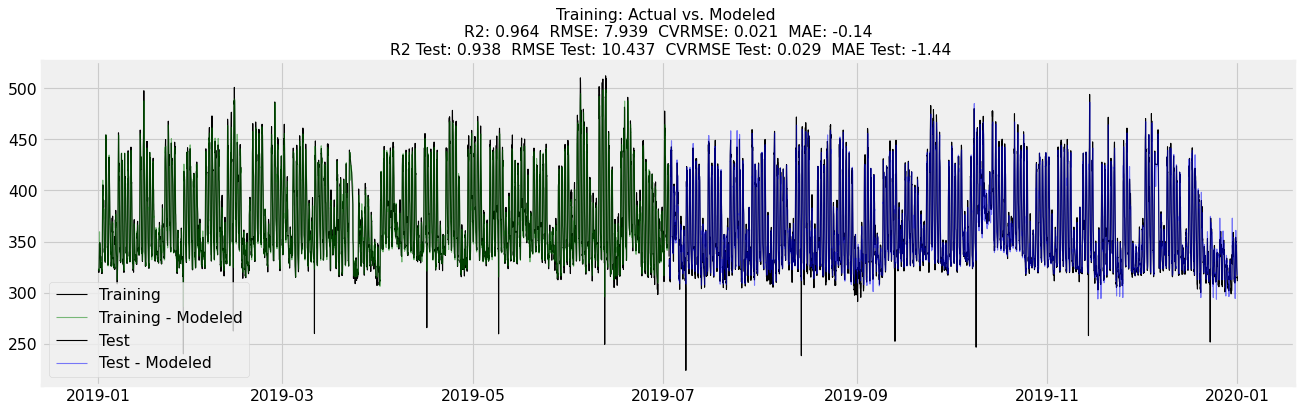

CPU times: user 5.02 s, sys: 66.6 ms, total: 5.09 s
Wall time: 9.79 s


In [27]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

rfr = create_rfr_model_hrs(data3, X, y, mod_inputs=mod_inputs)

In [28]:
rfr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 2,
 'max_leaf_nodes': 100,
 'max_depth': 10,
 'criterion': 'squared_error'}

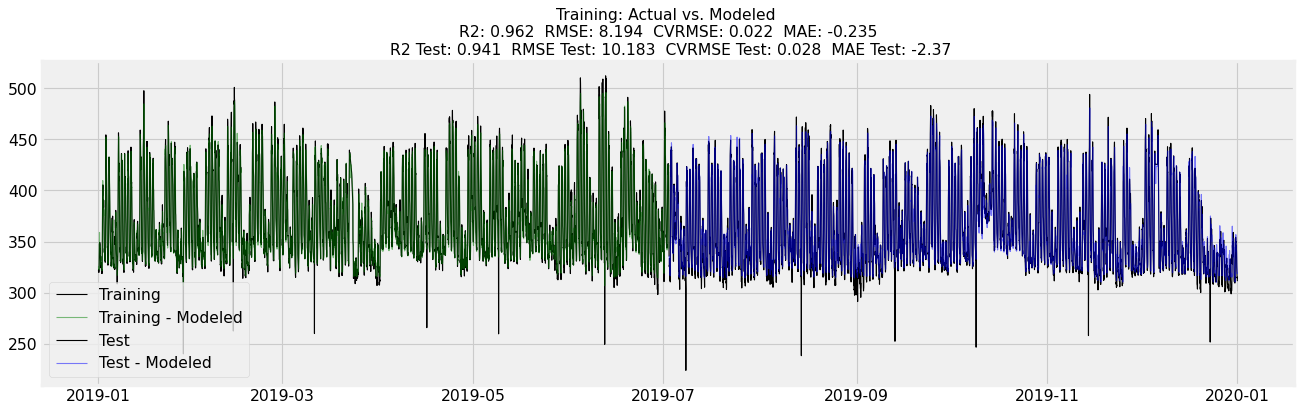

CPU times: user 3.44 s, sys: 66.3 ms, total: 3.51 s
Wall time: 7.15 s


In [29]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

etr = create_etr_model_hrs(data3, X, y, mod_inputs=mod_inputs)

In [30]:
etr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 2,
 'max_leaf_nodes': 100,
 'max_depth': 10,
 'criterion': 'squared_error'}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Training: Actual vs. Modeled 
 R2: 0.971  RMSE: 7.131  CVRMSE: 0.019  MAE: -0.109
Test: Actual vs. Modeled 
 R2: 0.942  RMSE: 10.131  CVRMSE: 0.028  MAE: -2.193


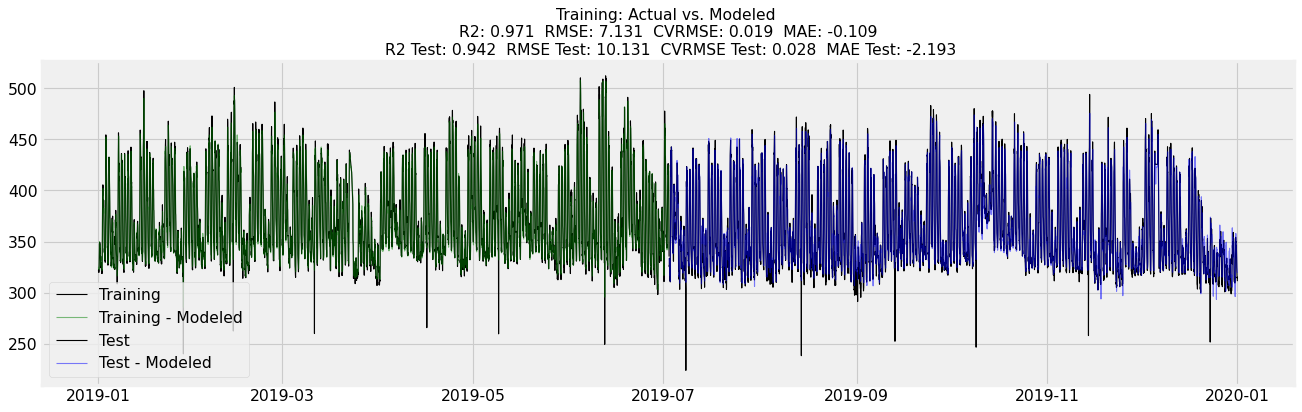

CPU times: user 1.24 s, sys: 38.3 ms, total: 1.28 s
Wall time: 1.32 s


In [31]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

mod_et = ExtraTreesRegressor(max_depth=10, n_estimators=100, random_state=mod_inputs['random_seed'],verbose = 1)

et = create_model(data2, X, y, mod_et, mod_inputs=mod_inputs)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Training: Actual vs. Modeled 
 R2: 0.974  RMSE: 6.777  CVRMSE: 0.018  MAE: -0.07
Test: Actual vs. Modeled 
 R2: 0.938  RMSE: 10.432  CVRMSE: 0.029  MAE: -1.402


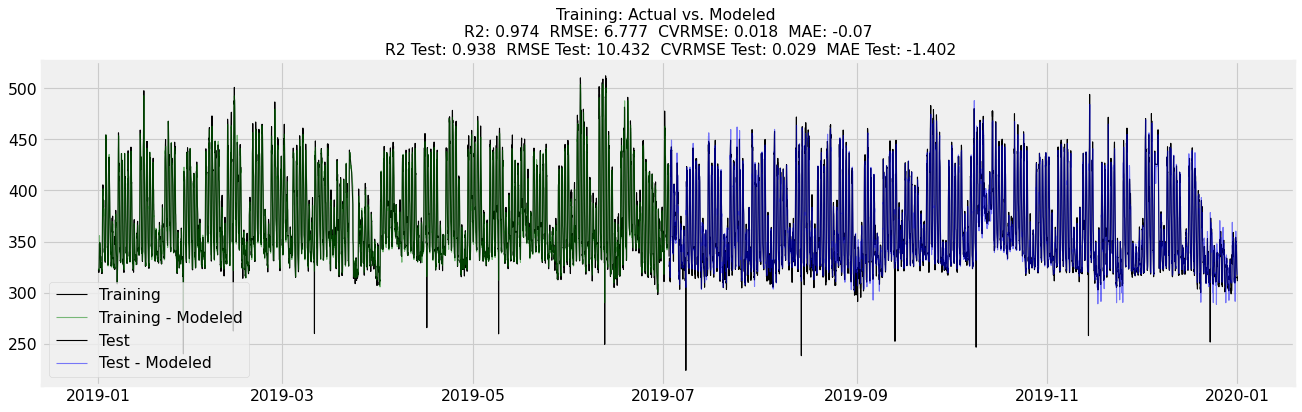

CPU times: user 1.63 s, sys: 35.7 ms, total: 1.66 s
Wall time: 1.68 s


In [32]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

mod_rf = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=mod_inputs['random_seed'],verbose = 1)

rf = create_model(data2, X, y, mod_rf, mod_inputs=mod_inputs)

# 2.  EPS w/o 'Ghausi_Electricity_Demand_kBtu'

In [16]:
tags = ['EPS.AHU.AHU01.RMAVG.Zone Air Temp', 'aiTIT4045']
start = '2019-01-01'
end = '2020-01-01'
interval = '1h'
calculation = 'summary'
summary_type = 'average'

In [21]:
data = pi.get_stream_by_point(tags=tags, start=start, end=end, interval=interval, calculation=calculation, _summary_type=summary_type)
data.head()

12:19:22: Sending API request... Chunk 1 of 1
12:19:24: Response recieved for 2 tags! (2.25)


EPS.AHU.AHU01.RMAVG.Zone Air Temp  aiTIT4045
Timestamp                                                        
2019-01-01 00:00:00                          71.674997  41.556886
2019-01-01 01:00:00                          71.674999  41.994667
2019-01-01 02:00:00                          71.612512  40.879091
2019-01-01 03:00:00                          71.712485  41.991956
2019-01-01 04:00:00                          71.599999  41.944634

In [22]:
data2 = create_standard_multivariable_df(data)
data2.head()

EPS.AHU.AHU01.RMAVG.Zone Air Temp   OAT  CDD   HDD  CDD2  \
Timestamp                                                                       
2019-01-01 01:00:00                          71.674999  42.0  0.0  23.0   0.0   
2019-01-01 02:00:00                          71.612512  41.0  0.0  24.0   0.0   
2019-01-01 03:00:00                          71.712485  42.0  0.0  23.0   0.0   
2019-01-01 04:00:00                          71.599999  42.0  0.0  23.0   0.0   
2019-01-01 05:00:00                          71.687511  42.0  0.0  23.0   0.0   

                      HDD2  WEEKEND    SHIFT_1  MONTH_2  MONTH_3  ...  TOD_20  \
Timestamp                                                         ...           
2019-01-01 01:00:00  529.0        0  71.674997      0.0      0.0  ...     0.0   
2019-01-01 02:00:00  582.0        0  71.674999      0.0      0.0  ...     0.0   
2019-01-01 03:00:00  529.0        0  71.612512      0.0      0.0  ...     0.0   
2019-01-01 04:00:00  532.0        0  71.712485      0.0      0.0  ...     0.0   
2019-01-01 05:00:00  524.0        0  71.599999      0.0      0.0  ...     0.0   

                     TOD_21  TOD_22  TOD_23  DOW_1  DOW_2  DOW_3  DOW_4  \
Timestamp                                                                 
2019-01-01 01:00:00     0.0     0.0     0.0    1.0    0.0    0.0    0.0   
2019-01-01 02:00:00     0.0     0.0     0.0    1.0    0.0    0.0    0.0   
2019-01-01 03:00:00     0.0     0.0     0.0    1.0    0.0    0.0    0.0   
2019-01-01 04:00:00     0.0     0.0     0.0    1.0    0.0    0.0    0.0   
2019-01-01 05:00:00     0.0     0.0     0.0    1.0    0.0    0.0    0.0   

                     DOW_5  DOW_6  
Timestamp                          
2019-01-01 01:00:00    0.0    0.0  
2019-01-01 02:00:00    0.0    0.0  
2019-01-01 03:00:00    0.0    0.0  
2019-01-01 04:00:00    0.0    0.0  
2019-01-01 05:00:00    0.0    0.0  

[5 rows x 48 columns]

In [19]:
data3 = clean_data(data2, 'EPS.AHU.AHU01.RMAVG.Zone Air Temp')

In [23]:
y = data3.iloc[:,0]
X = data3.iloc[:,1:]

In [24]:
y


Timestamp
2019-01-01 01:00:00    71.674999
2019-01-01 02:00:00    71.612512
2019-01-01 03:00:00    71.712485
2019-01-01 04:00:00    71.599999
2019-01-01 05:00:00    71.687511
                         ...    
2019-12-31 19:00:00    71.361933
2019-12-31 20:00:00    71.286366
2019-12-31 21:00:00    71.268184
2019-12-31 22:00:00    71.250002
2019-12-31 23:00:00    71.231820
Name: EPS.AHU.AHU01.RMAVG.Zone Air Temp, Length: 8696, dtype: float64

In [25]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

gbr = create_gbr_model_hrs(data3, X, y, mod_inputs=mod_inputs)

CPU times: user 7.78 s, sys: 251 ms, total: 8.03 s
Wall time: 12.5 s


In [26]:
gbr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 5,
 'max_leaf_nodes': 200,
 'max_depth': 10,
 'loss': 'ls',
 'learning_rate': 0.01,
 'criterion': 'friedman_mse'}

In [27]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

rfr = create_rfr_model_hrs(data3, X, y, mod_inputs=mod_inputs)

CPU times: user 3min 25s, sys: 1.09 s, total: 3min 26s
Wall time: 3min 50s


In [28]:
rfr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 2,
 'max_leaf_nodes': 10,
 'max_depth': 50,
 'criterion': 'absolute_error'}

In [29]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

etr = create_etr_model_hrs(data3, X, y, mod_inputs=mod_inputs)

CPU times: user 3.27 s, sys: 50.7 ms, total: 3.32 s
Wall time: 10.6 s


In [30]:
etr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 2,
 'max_leaf_nodes': 100,
 'max_depth': 10,
 'criterion': 'squared_error'}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Training: Actual vs. Modeled 
 R2: 0.929  RMSE: 0.071  CVRMSE: 0.001  MAE: 0.0
Test: Actual vs. Modeled 
 R2: 0.787  RMSE: 0.187  CVRMSE: 0.003  MAE: -0.04


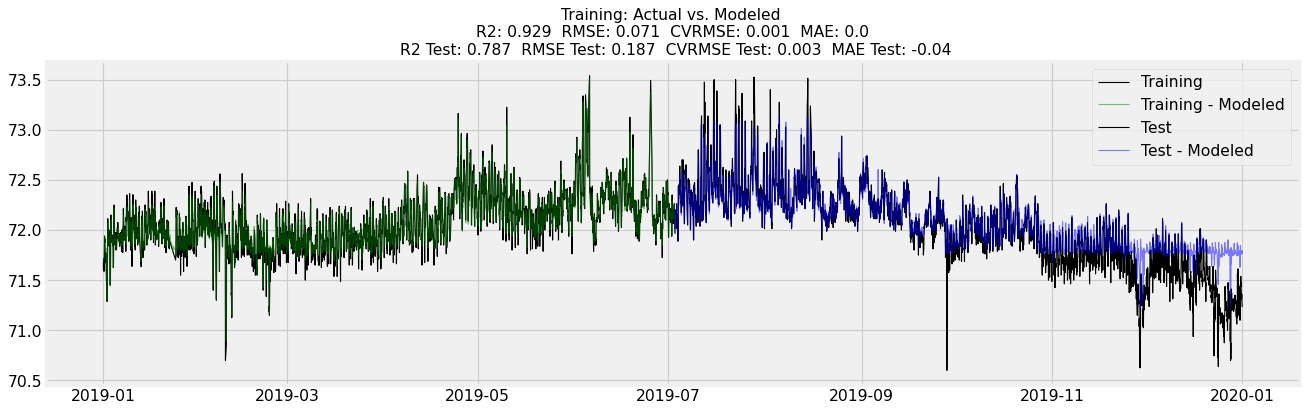

CPU times: user 1.23 s, sys: 39.2 ms, total: 1.26 s
Wall time: 1.32 s


In [31]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

mod_et = ExtraTreesRegressor(max_depth=10, n_estimators=100, random_state=mod_inputs['random_seed'],verbose = 1)

et = create_model(data3, X, y, mod_et, mod_inputs=mod_inputs)

In [32]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

mod_rf = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=mod_inputs['random_seed'],verbose = 1)

rf = create_model(data3, X, y, mod_rf, mod_inputs=mod_inputs)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Training: Actual vs. Modeled 
 R2: 0.932  RMSE: 0.069  CVRMSE: 0.001  MAE: 0.001
Test: Actual vs. Modeled 
 R2: 0.863  RMSE: 0.15  CVRMSE: 0.002  MAE: -0.024


CPU times: user 1.56 s, sys: 37.7 ms, total: 1.59 s
Wall time: 1.61 s


# Other tags

In [32]:
#'ACAD.AHU.AHU01.Supply Air Temp',
#'ACAD.AHU.AHU0.Supply Air Temp',
#'BJ1.AHU.AC07.Supply Air Temp',
#'BJ1.AHU.AC08.Supply Air Temp',
#'ACAD.AHU.AHU01.Supply Air Temp Setpoint',
#'ACAD.AHU.AHU01.Supply Air Temp Setpoint',
#'CHEMX.AHU.SF1N.Heating Valve Control Output',
#'CHEMX.AHU.SF1S.Heating Valve Control Output'

## 'ACAD.AHU.AHU01.Supply Air Temp'

In [206]:
tags = ['ACAD.AHU.AHU01.Supply Air Temp', 'aiTIT4045']
start = '2019-01-01'
end = '2020-01-01'
interval = '1h'
calculation = 'summary'
summary_type = 'average'

In [207]:
data = pi.get_stream_by_point(tags=tags, start=start, end=end, interval=interval, calculation=calculation, _summary_type=summary_type)
#data.head()

13:06:35: Sending API request... Chunk 1 of 1
13:06:37: Response recieved for 2 tags! (2.03)


In [208]:
data2 = create_standard_multivariable_df(data)
#data2.head()

In [209]:
data3 = clean_data(data2, 'ACAD.AHU.AHU01.Supply Air Temp')

In [210]:
y = data3.iloc[:,0]
X = data3.iloc[:,1:]

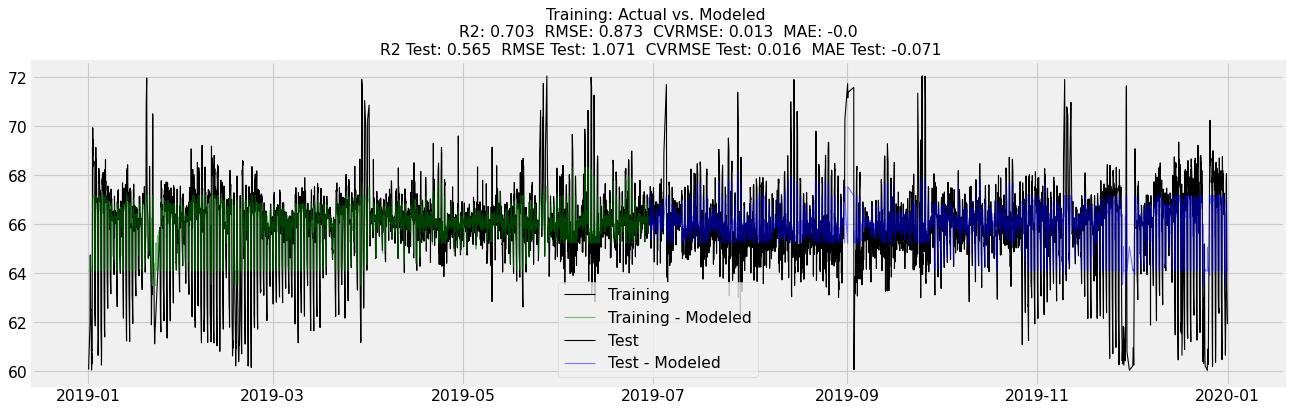

CPU times: user 15.6 s, sys: 120 ms, total: 15.7 s
Wall time: 18.3 s


In [51]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

gbr = create_gbr_model_hrs(data3, X, y, mod_inputs=mod_inputs)

In [52]:
gbr

{'random_state': 42,
 'n_estimators': 100,
 'min_samples_split': 2,
 'max_leaf_nodes': 200,
 'max_depth': 10,
 'loss': 'lad',
 'learning_rate': 0.01,
 'criterion': 'friedman_mse'}

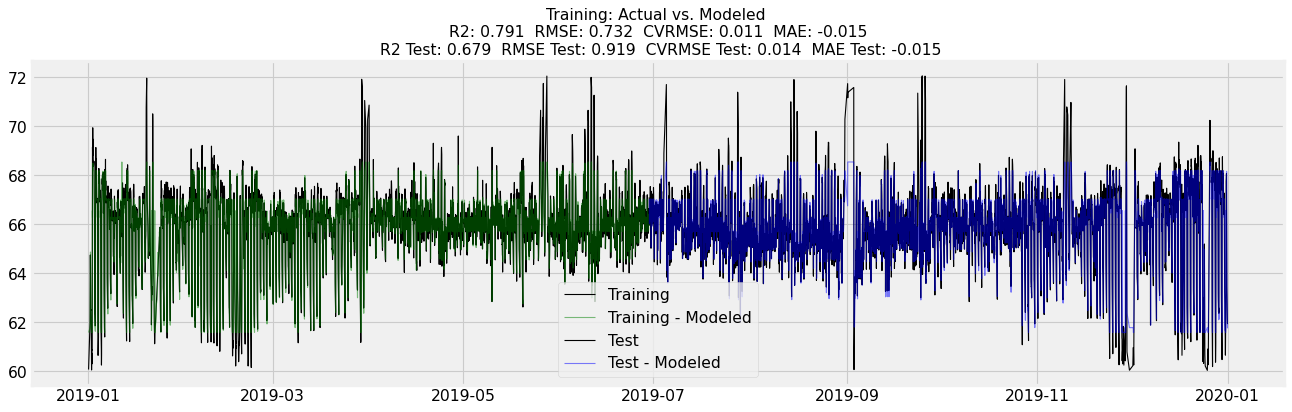

CPU times: user 3min 39s, sys: 469 ms, total: 3min 39s
Wall time: 3min 45s


In [177]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

rfr = create_rfr_model_hrs(data3, X, y, mod_inputs=mod_inputs)

In [54]:
rfr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 2,
 'max_leaf_nodes': 10,
 'max_depth': 50,
 'criterion': 'absolute_error'}

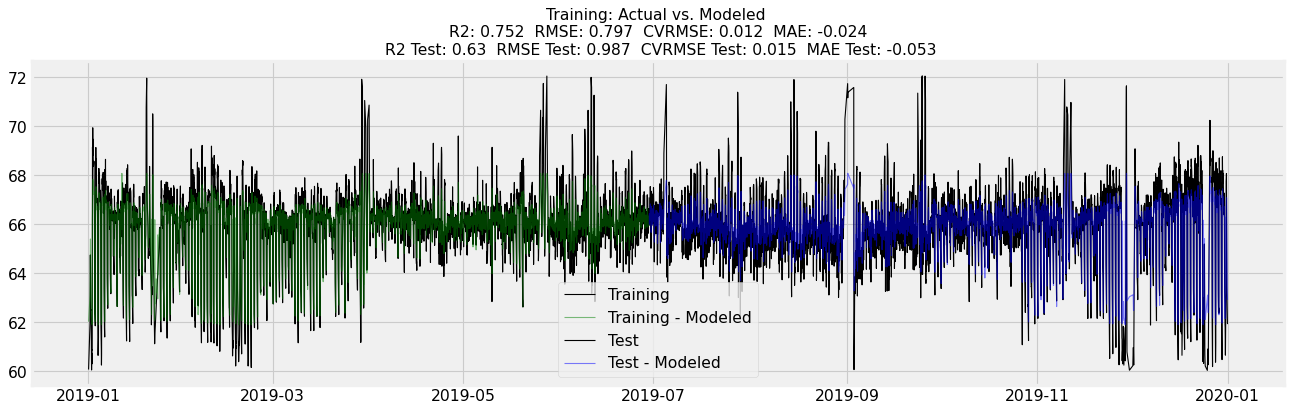

CPU times: user 12min 22s, sys: 2.47 s, total: 12min 25s
Wall time: 13min 6s


In [211]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

etr = create_etr_model_hrs(data3, X, y, mod_inputs=mod_inputs)

In [212]:
etr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 2,
 'max_leaf_nodes': 10,
 'max_depth': 50,
 'criterion': 'absolute_error'}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Training: Actual vs. Modeled 
 R2: 0.923  RMSE: 0.445  CVRMSE: 0.007  MAE: -0.008
Test: Actual vs. Modeled 
 R2: 0.769  RMSE: 0.78  CVRMSE: 0.012  MAE: -0.039


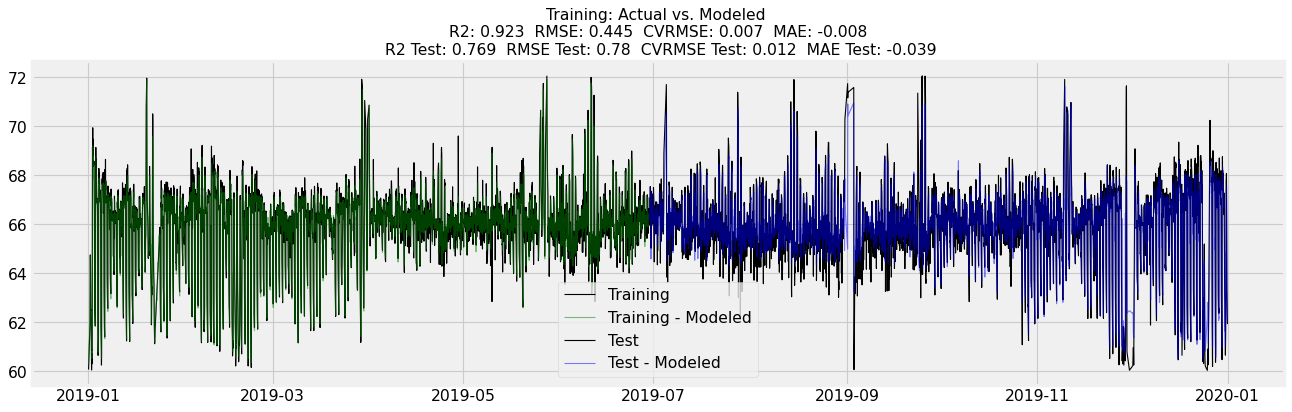

CPU times: user 1.24 s, sys: 36.8 ms, total: 1.28 s
Wall time: 1.3 s


In [57]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

mod_et = ExtraTreesRegressor(max_depth=10, n_estimators=100, random_state=mod_inputs['random_seed'],verbose = 1)

et = create_model(data2, X, y, mod_et, mod_inputs=mod_inputs)

In [58]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

mod_rf = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=mod_inputs['random_seed'],verbose = 1)

rf = create_model(data3, X, y, mod_rf, mod_inputs=mod_inputs)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


Training: Actual vs. Modeled 
 R2: 0.927  RMSE: 0.432  CVRMSE: 0.007  MAE: -0.007
Test: Actual vs. Modeled 
 R2: 0.764  RMSE: 0.789  CVRMSE: 0.012  MAE: -0.044


CPU times: user 1.92 s, sys: 60.2 ms, total: 1.98 s
Wall time: 2.39 s


## 'ACAD.AHU.AHU02.Supply Air Temp'

In [178]:
tags = ['ACAD.AHU.AHU02.Supply Air Temp', 'aiTIT4045']
start = '2019-01-01'
end = '2020-01-01'
interval = '1h'
calculation = 'summary'
summary_type = 'average'

In [179]:
data = pi.get_stream_by_point(tags=tags, start=start, end=end, interval=interval, calculation=calculation, _summary_type=summary_type)
#data.head()

12:58:16: Sending API request... Chunk 1 of 1
12:58:18: Response recieved for 2 tags! (1.98)


In [180]:
data2 = create_standard_multivariable_df(data)
#data2.head()

In [181]:
data3 = clean_data(data2, 'ACAD.AHU.AHU02.Supply Air Temp')

In [182]:
y = data3.iloc[:,0]
X = data3.iloc[:,1:]

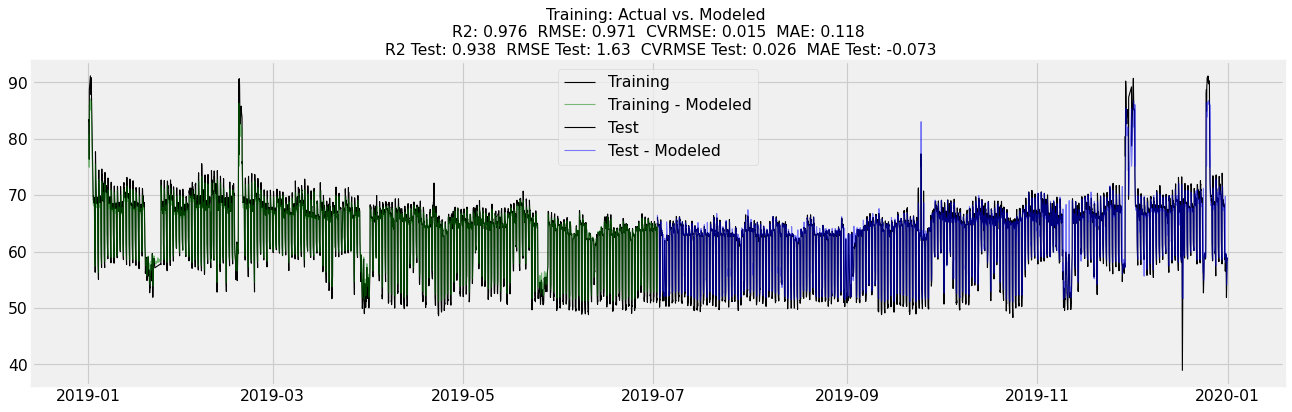

CPU times: user 7.12 s, sys: 114 ms, total: 7.24 s
Wall time: 10.4 s


In [64]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

gbr = create_gbr_model_hrs(data3, X, y, mod_inputs=mod_inputs)

In [65]:
gbr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 5,
 'max_leaf_nodes': 200,
 'max_depth': 10,
 'loss': 'ls',
 'learning_rate': 0.01,
 'criterion': 'friedman_mse'}

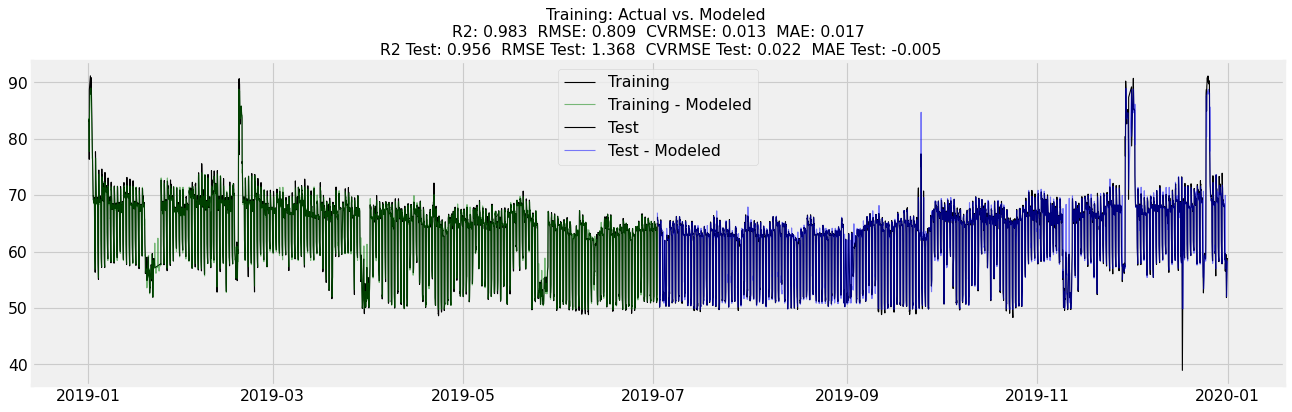

CPU times: user 4.81 s, sys: 51.9 ms, total: 4.86 s
Wall time: 9.67 s


In [183]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

rfr = create_rfr_model_hrs(data3, X, y, mod_inputs=mod_inputs)

In [184]:
rfr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 2,
 'max_leaf_nodes': 100,
 'max_depth': 10,
 'criterion': 'squared_error'}

In [68]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

etr = create_etr_model_hrs(data3, X, y, mod_inputs=mod_inputs)

CPU times: user 3.98 s, sys: 86.8 ms, total: 4.07 s
Wall time: 8.51 s


In [69]:
etr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 2,
 'max_leaf_nodes': 100,
 'max_depth': 10,
 'criterion': 'squared_error'}

In [70]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

mod_et = ExtraTreesRegressor(max_depth=10, n_estimators=100, random_state=mod_inputs['random_seed'],verbose = 1)

et = create_model(data2, X, y, mod_et, mod_inputs=mod_inputs)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Training: Actual vs. Modeled 
 R2: 0.985  RMSE: 0.756  CVRMSE: 0.012  MAE: 0.008
Test: Actual vs. Modeled 
 R2: 0.957  RMSE: 1.354  CVRMSE: 0.022  MAE: -0.066


CPU times: user 1.25 s, sys: 39.9 ms, total: 1.29 s
Wall time: 1.31 s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Training: Actual vs. Modeled 
 R2: 0.989  RMSE: 0.656  CVRMSE: 0.01  MAE: -0.002
Test: Actual vs. Modeled 
 R2: 0.957  RMSE: 1.357  CVRMSE: 0.022  MAE: -0.007


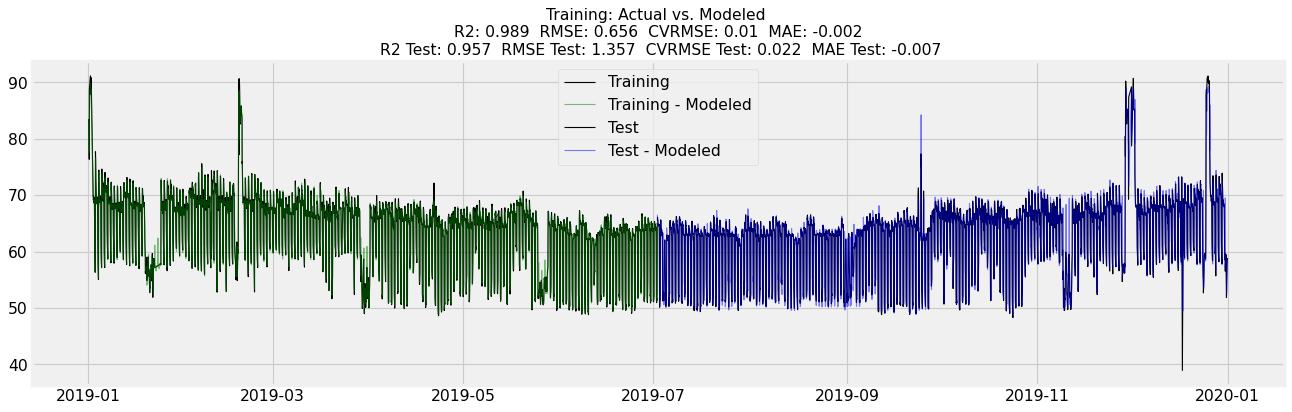

CPU times: user 1.9 s, sys: 63.1 ms, total: 1.96 s
Wall time: 2.19 s


In [71]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

mod_rf = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=mod_inputs['random_seed'],verbose = 1)

rf = create_model(data3, X, y, mod_rf, mod_inputs=mod_inputs)

## 'BJ1.AHU.AC07.Supply Air Temp'

In [185]:
tags = ['BJ1.AHU.AC07.Supply Air Temp', 'aiTIT4045']
start = '2020-01-01'
end = '2021-01-01'
interval = '1h'
calculation = 'summary'
summary_type = 'average'

In [186]:
data = pi.get_stream_by_point(tags=tags, start=start, end=end, interval=interval, calculation=calculation, _summary_type=summary_type)
#data.head()

12:58:53: Sending API request... Chunk 1 of 1
12:58:54: Response recieved for 2 tags! (0.94)


In [187]:
data2 = create_standard_multivariable_df(data)
#data2.head()

In [188]:
data3 = clean_data(data2, 'BJ1.AHU.AC07.Supply Air Temp')

In [189]:
y = data3.iloc[:,0]
X = data3.iloc[:,1:]

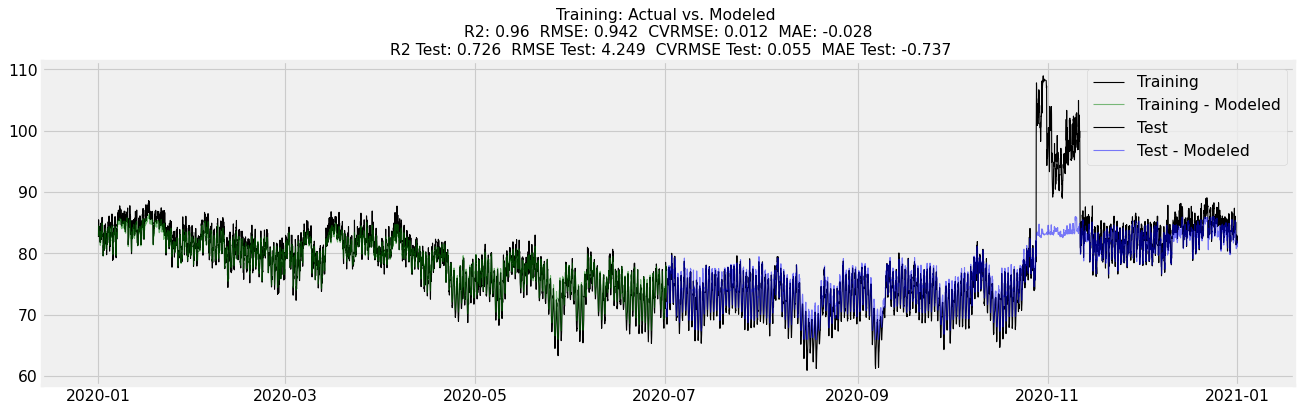

CPU times: user 8.34 s, sys: 151 ms, total: 8.49 s
Wall time: 11.8 s


In [77]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

gbr = create_gbr_model_hrs(data3, X, y, mod_inputs=mod_inputs)

In [78]:
gbr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 5,
 'max_leaf_nodes': 200,
 'max_depth': 10,
 'loss': 'ls',
 'learning_rate': 0.01,
 'criterion': 'friedman_mse'}

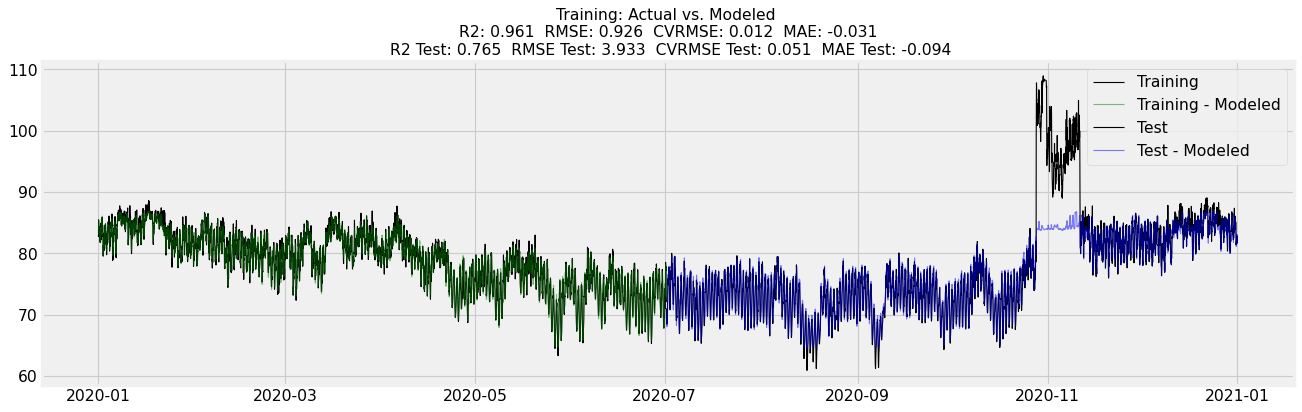

CPU times: user 4.56 s, sys: 50.1 ms, total: 4.61 s
Wall time: 9.02 s


In [190]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

rfr = create_rfr_model_hrs(data3, X, y, mod_inputs=mod_inputs)

In [191]:
rfr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 2,
 'max_leaf_nodes': 100,
 'max_depth': 10,
 'criterion': 'squared_error'}

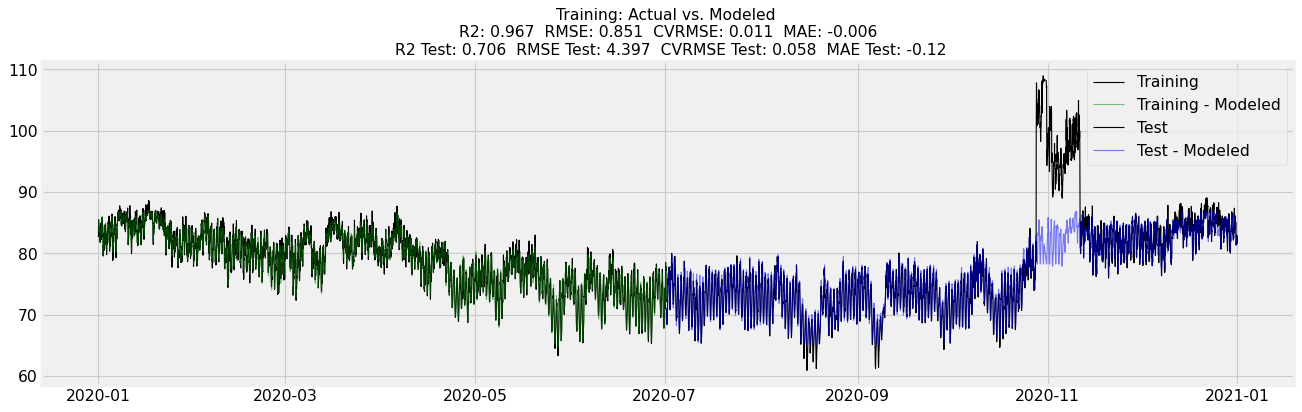

CPU times: user 724 ms, sys: 60.6 ms, total: 785 ms
Wall time: 4.43 s


In [81]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

etr = create_etr_model_hrs(data3, X, y, mod_inputs=mod_inputs)

In [82]:
etr

{'random_state': 42,
 'n_estimators': 10,
 'min_samples_split': 2,
 'max_leaf_nodes': 200,
 'max_depth': 50,
 'criterion': 'squared_error'}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Training: Actual vs. Modeled 
 R2: 0.972  RMSE: 0.782  CVRMSE: 0.01  MAE: -0.009
Test: Actual vs. Modeled 
 R2: 0.713  RMSE: 4.345  CVRMSE: 0.057  MAE: -0.102


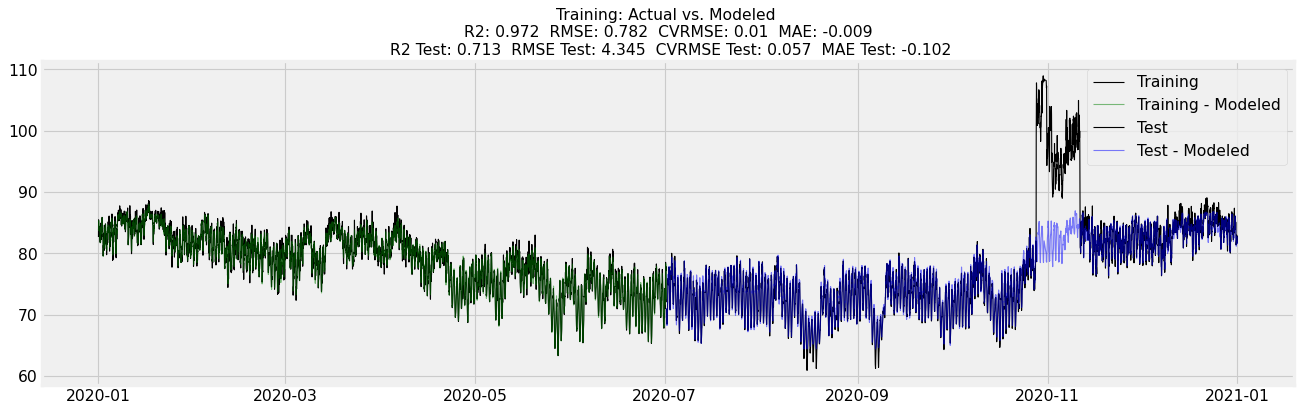

CPU times: user 1.4 s, sys: 44 ms, total: 1.44 s
Wall time: 1.55 s


In [83]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

mod_et = ExtraTreesRegressor(max_depth=10, n_estimators=100, random_state=mod_inputs['random_seed'],verbose = 1)

et = create_model(data2, X, y, mod_et, mod_inputs=mod_inputs)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Training: Actual vs. Modeled 
 R2: 0.974  RMSE: 0.761  CVRMSE: 0.01  MAE: -0.013
Test: Actual vs. Modeled 
 R2: 0.77  RMSE: 3.887  CVRMSE: 0.051  MAE: -0.069


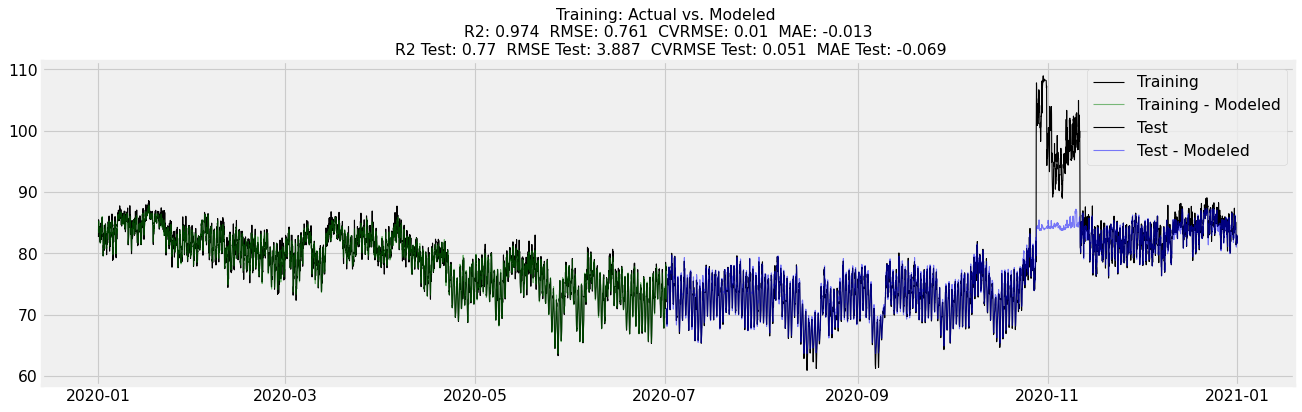

CPU times: user 1.62 s, sys: 38.1 ms, total: 1.66 s
Wall time: 1.68 s


In [84]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

mod_rf = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=mod_inputs['random_seed'],verbose = 1)

rf = create_model(data3, X, y, mod_rf, mod_inputs=mod_inputs)

## 'BJ1.AHU.AC08.Supply Air Temp'

In [85]:
tags = ['BJ1.AHU.AC08.Supply Air Temp', 'aiTIT4045']
start = '2020-01-01'
end = '2021-01-01'
interval = '1h'
calculation = 'summary'
summary_type = 'average'

In [86]:
data = pi.get_stream_by_point(tags=tags, start=start, end=end, interval=interval, calculation=calculation, _summary_type=summary_type)
#data.head()

12:22:55: Sending API request... Chunk 1 of 1
12:22:56: Response recieved for 2 tags! (1.13)


In [87]:
data2 = create_standard_multivariable_df(data)
#data2.head()

In [88]:
data3 = clean_data(data2, 'BJ1.AHU.AC08.Supply Air Temp')

In [89]:
y = data3.iloc[:,0]
X = data3.iloc[:,1:]

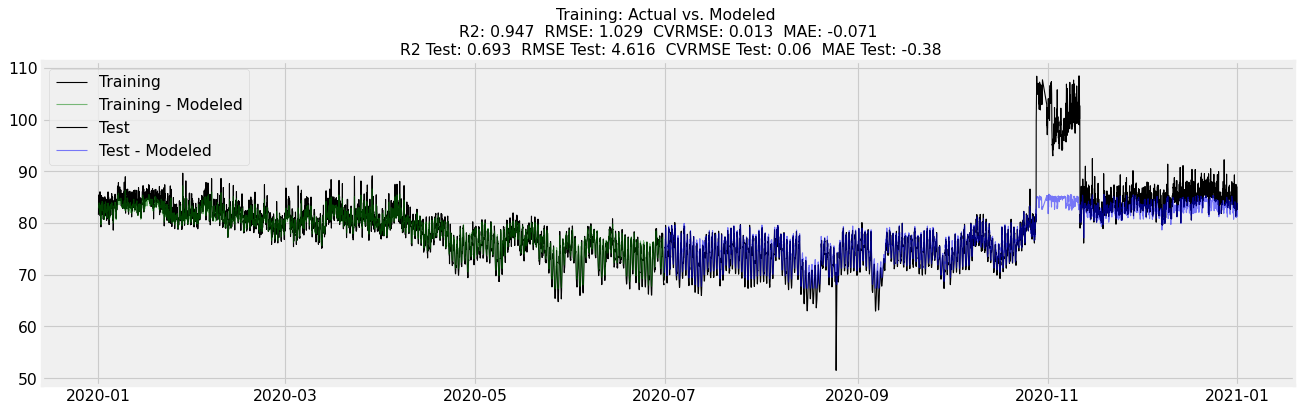

CPU times: user 7.42 s, sys: 85.1 ms, total: 7.51 s
Wall time: 10.3 s


In [90]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

gbr = create_gbr_model_hrs(data3, X, y, mod_inputs=mod_inputs)

In [91]:
gbr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 5,
 'max_leaf_nodes': 200,
 'max_depth': 10,
 'loss': 'ls',
 'learning_rate': 0.01,
 'criterion': 'friedman_mse'}

In [92]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

rfr = create_rfr_model_hrs(data3, X, y, mod_inputs=mod_inputs)

CPU times: user 5.14 s, sys: 96.5 ms, total: 5.24 s
Wall time: 11.2 s


In [93]:
rfr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 2,
 'max_leaf_nodes': 100,
 'max_depth': 10,
 'criterion': 'squared_error'}

In [94]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

etr = create_etr_model_hrs(data3, X, y, mod_inputs=mod_inputs)

CPU times: user 1.88 s, sys: 45.6 ms, total: 1.93 s
Wall time: 6.3 s


In [95]:
etr

{'random_state': 42,
 'n_estimators': 100,
 'min_samples_split': 2,
 'max_leaf_nodes': 100,
 'max_depth': 10,
 'criterion': 'squared_error'}

In [96]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

mod_et = ExtraTreesRegressor(max_depth=10, n_estimators=100, random_state=mod_inputs['random_seed'],verbose = 1)

et = create_model(data2, X, y, mod_et, mod_inputs=mod_inputs)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Training: Actual vs. Modeled 
 R2: 0.954  RMSE: 0.957  CVRMSE: 0.012  MAE: -0.017
Test: Actual vs. Modeled 
 R2: 0.658  RMSE: 4.871  CVRMSE: 0.063  MAE: 0.108


CPU times: user 1.33 s, sys: 43.8 ms, total: 1.37 s
Wall time: 1.42 s


In [97]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

mod_rf = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=mod_inputs['random_seed'],verbose = 1)

rf = create_model(data3, X, y, mod_rf, mod_inputs=mod_inputs)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


Training: Actual vs. Modeled 
 R2: 0.957  RMSE: 0.926  CVRMSE: 0.012  MAE: -0.01
Test: Actual vs. Modeled 
 R2: 0.713  RMSE: 4.466  CVRMSE: 0.058  MAE: 0.156


CPU times: user 2.05 s, sys: 76 ms, total: 2.13 s
Wall time: 2.72 s


## 'ACAD.AHU.AHU01.Supply Air Temp Setpoint'

In [192]:
tags = ['ACAD.AHU.AHU01.Supply Air Temp Setpoint', 'aiTIT4045']
start = '2019-01-01'
end = '2020-01-01'
interval = '1h'
calculation = 'summary'
summary_type = 'average'

In [193]:
data = pi.get_stream_by_point(tags=tags, start=start, end=end, interval=interval, calculation=calculation, _summary_type=summary_type)
#data.head()

12:59:32: Sending API request... Chunk 1 of 1
12:59:34: Response recieved for 2 tags! (1.85)


In [194]:
data2 = create_standard_multivariable_df(data)
#data2.head()

In [195]:
data3 = clean_data(data2, 'ACAD.AHU.AHU01.Supply Air Temp Setpoint')

In [196]:
y = data3.iloc[:,0]
X = data3.iloc[:,1:]

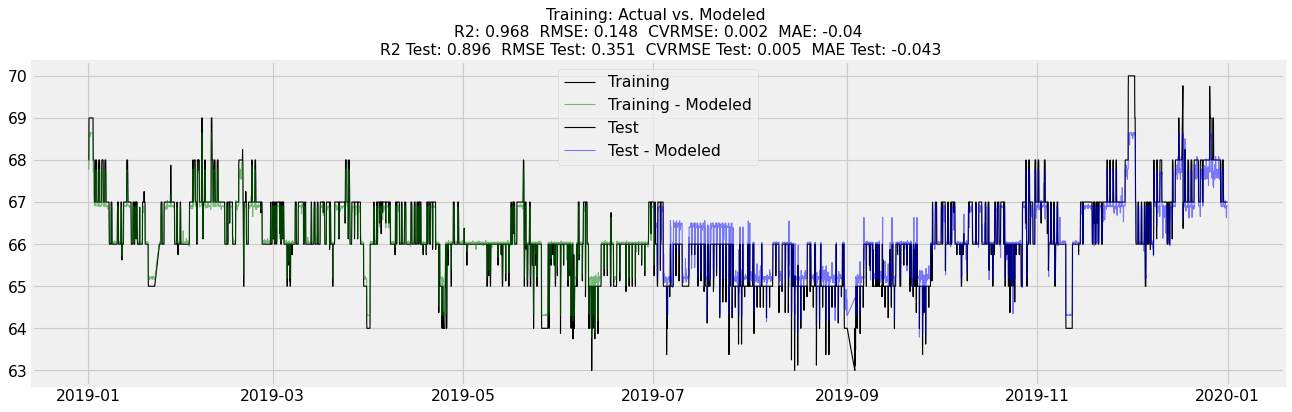

CPU times: user 5.9 s, sys: 44.5 ms, total: 5.94 s
Wall time: 8.04 s


In [103]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

gbr = create_gbr_model_hrs(data3, X, y, mod_inputs=mod_inputs)

In [104]:
gbr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 5,
 'max_leaf_nodes': 200,
 'max_depth': 10,
 'loss': 'ls',
 'learning_rate': 0.01,
 'criterion': 'friedman_mse'}

In [197]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

rfr = create_rfr_model_hrs(data3, X, y, mod_inputs=mod_inputs)

CPU times: user 2min 43s, sys: 173 ms, total: 2min 43s
Wall time: 2min 47s


In [198]:
rfr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 2,
 'max_leaf_nodes': 10,
 'max_depth': 50,
 'criterion': 'absolute_error'}

In [107]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

etr = create_etr_model_hrs(data3, X, y, mod_inputs=mod_inputs)

CPU times: user 2.14 s, sys: 135 ms, total: 2.27 s
Wall time: 6.5 s


In [108]:
etr

{'random_state': 42,
 'n_estimators': 100,
 'min_samples_split': 2,
 'max_leaf_nodes': 100,
 'max_depth': 10,
 'criterion': 'squared_error'}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Training: Actual vs. Modeled 
 R2: 0.978  RMSE: 0.122  CVRMSE: 0.002  MAE: -0.002
Test: Actual vs. Modeled 
 R2: 0.931  RMSE: 0.286  CVRMSE: 0.004  MAE: -0.014


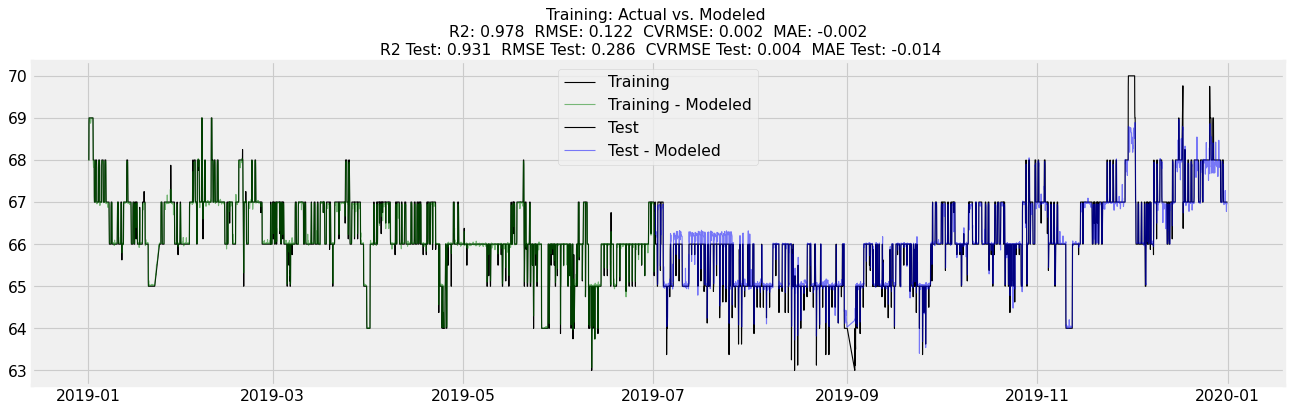

CPU times: user 1.27 s, sys: 43 ms, total: 1.31 s
Wall time: 1.39 s


In [109]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

mod_et = ExtraTreesRegressor(max_depth=10, n_estimators=100, random_state=mod_inputs['random_seed'],verbose = 1)

et = create_model(data2, X, y, mod_et, mod_inputs=mod_inputs)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


Training: Actual vs. Modeled 
 R2: 0.979  RMSE: 0.119  CVRMSE: 0.002  MAE: -0.001
Test: Actual vs. Modeled 
 R2: 0.935  RMSE: 0.278  CVRMSE: 0.004  MAE: -0.002


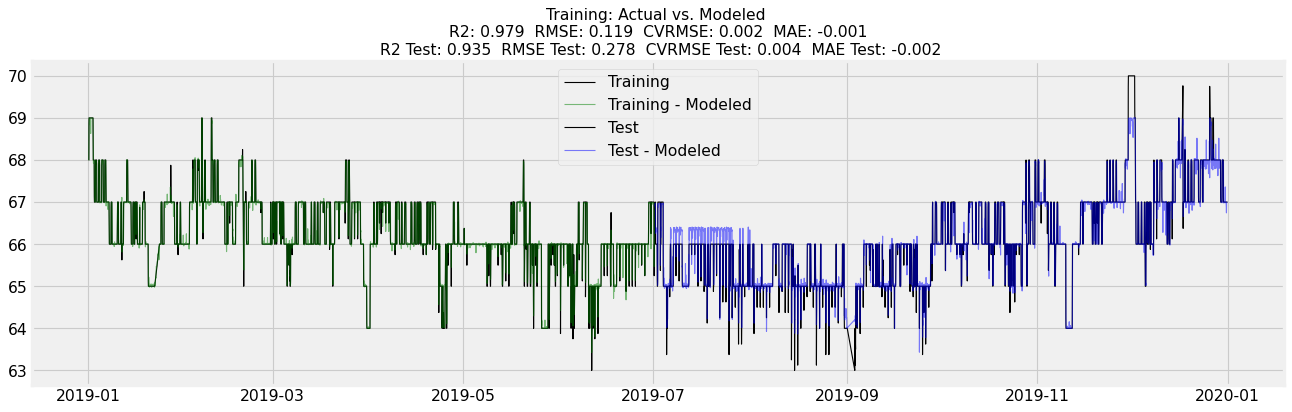

CPU times: user 1.74 s, sys: 67.8 ms, total: 1.81 s
Wall time: 2.21 s


In [110]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

mod_rf = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=mod_inputs['random_seed'],verbose = 1)

rf = create_model(data3, X, y, mod_rf, mod_inputs=mod_inputs)

## 'ACAD.AHU.AHU01.Supply Air Temp Setpoint'

In [199]:
tags = ['ACAD.AHU.AHU01.Supply Air Temp Setpoint', 'aiTIT4045']
start = '2019-01-01'
end = '2020-01-01'
interval = '1h'
calculation = 'summary'
summary_type = 'average'

In [200]:
data = pi.get_stream_by_point(tags=tags, start=start, end=end, interval=interval, calculation=calculation, _summary_type=summary_type)
#data.head()

13:02:52: Sending API request... Chunk 1 of 1
13:02:54: Response recieved for 2 tags! (1.92)


In [201]:
data2 = create_standard_multivariable_df(data)
#data2.head()

In [202]:
data3 = clean_data(data2, 'ACAD.AHU.AHU01.Supply Air Temp Setpoint')

In [203]:
y = data3.iloc[:,0]
X = data3.iloc[:,1:]

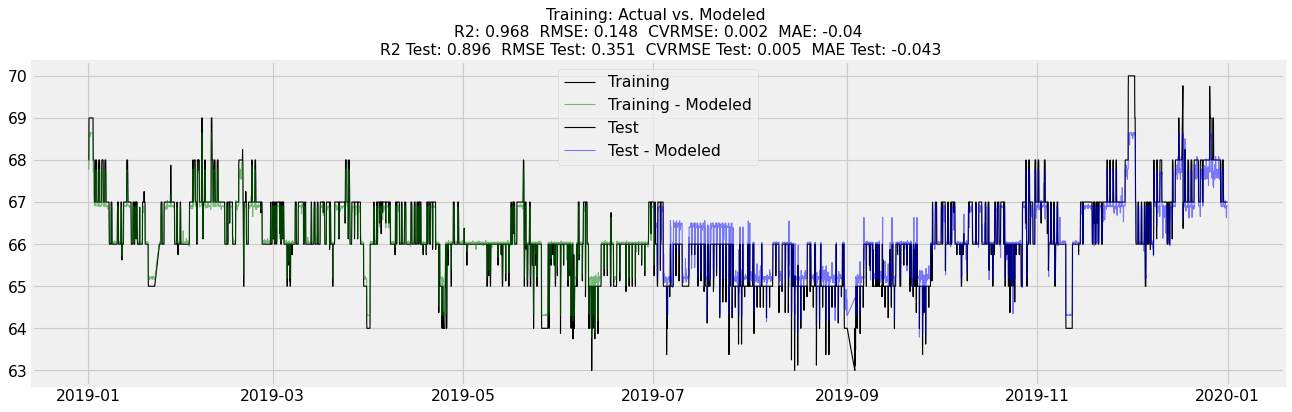

CPU times: user 6 s, sys: 57.7 ms, total: 6.05 s
Wall time: 7.78 s


In [116]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

gbr = create_gbr_model_hrs(data3, X, y, mod_inputs=mod_inputs)

In [117]:
gbr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 5,
 'max_leaf_nodes': 200,
 'max_depth': 10,
 'loss': 'ls',
 'learning_rate': 0.01,
 'criterion': 'friedman_mse'}

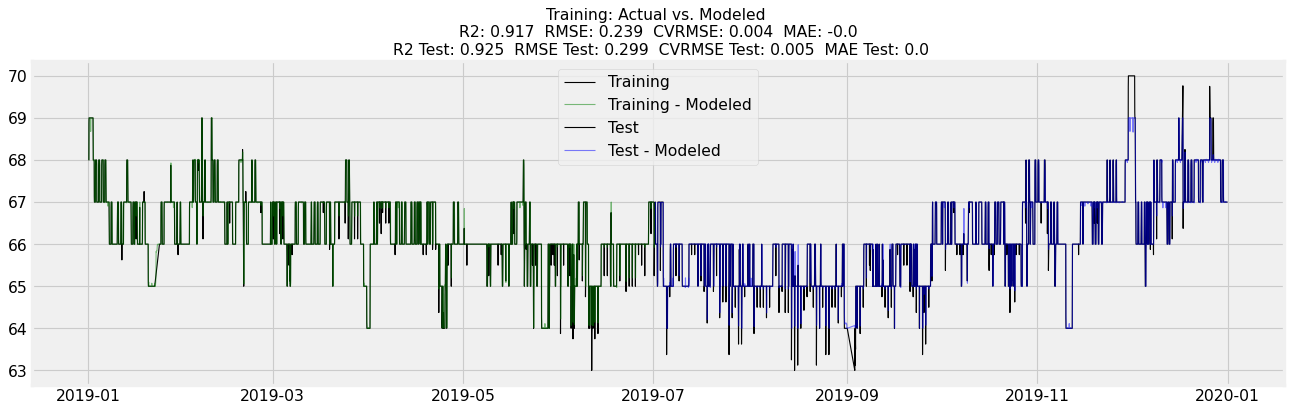

CPU times: user 2min 42s, sys: 174 ms, total: 2min 43s
Wall time: 2min 47s


In [204]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

rfr = create_rfr_model_hrs(data3, X, y, mod_inputs=mod_inputs)

In [205]:
rfr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 2,
 'max_leaf_nodes': 10,
 'max_depth': 50,
 'criterion': 'absolute_error'}

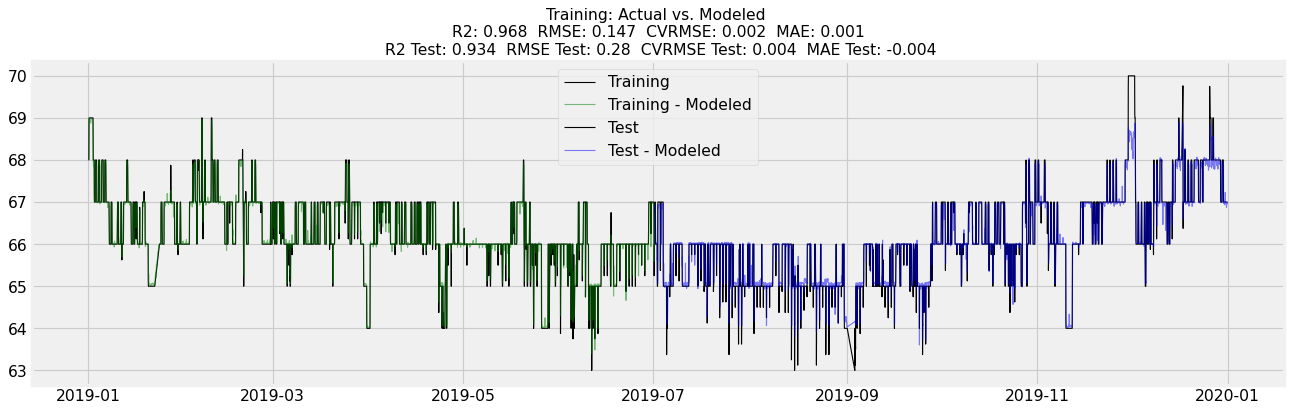

CPU times: user 1.77 s, sys: 106 ms, total: 1.87 s
Wall time: 5.83 s


In [120]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

etr = create_etr_model_hrs(data3, X, y, mod_inputs=mod_inputs)

In [121]:
etr

{'random_state': 42,
 'n_estimators': 100,
 'min_samples_split': 2,
 'max_leaf_nodes': 100,
 'max_depth': 10,
 'criterion': 'squared_error'}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Training: Actual vs. Modeled 
 R2: 0.978  RMSE: 0.122  CVRMSE: 0.002  MAE: -0.002
Test: Actual vs. Modeled 
 R2: 0.931  RMSE: 0.286  CVRMSE: 0.004  MAE: -0.014


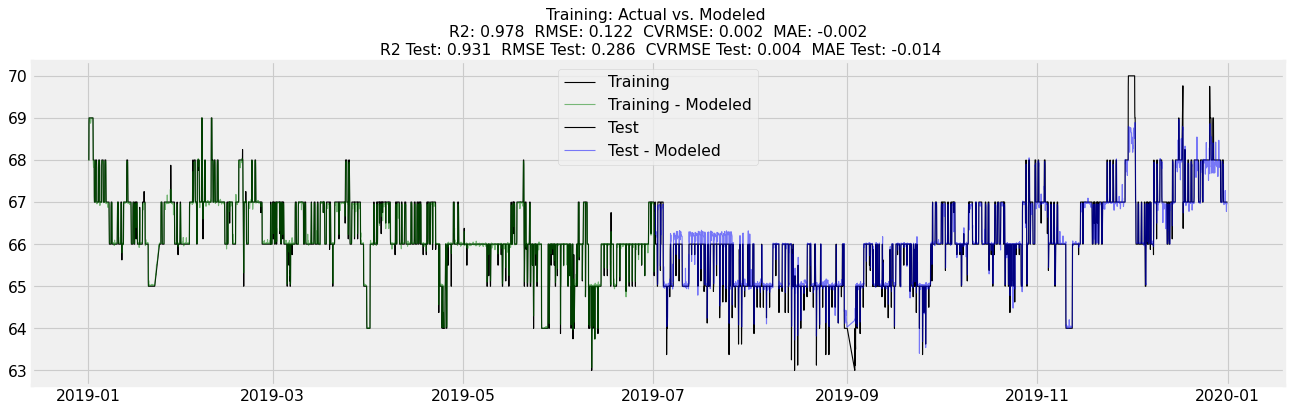

CPU times: user 1.17 s, sys: 37.8 ms, total: 1.21 s
Wall time: 1.24 s


In [122]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

mod_et = ExtraTreesRegressor(max_depth=10, n_estimators=100, random_state=mod_inputs['random_seed'],verbose = 1)

et = create_model(data2, X, y, mod_et, mod_inputs=mod_inputs)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Training: Actual vs. Modeled 
 R2: 0.979  RMSE: 0.119  CVRMSE: 0.002  MAE: -0.001
Test: Actual vs. Modeled 
 R2: 0.935  RMSE: 0.278  CVRMSE: 0.004  MAE: -0.002


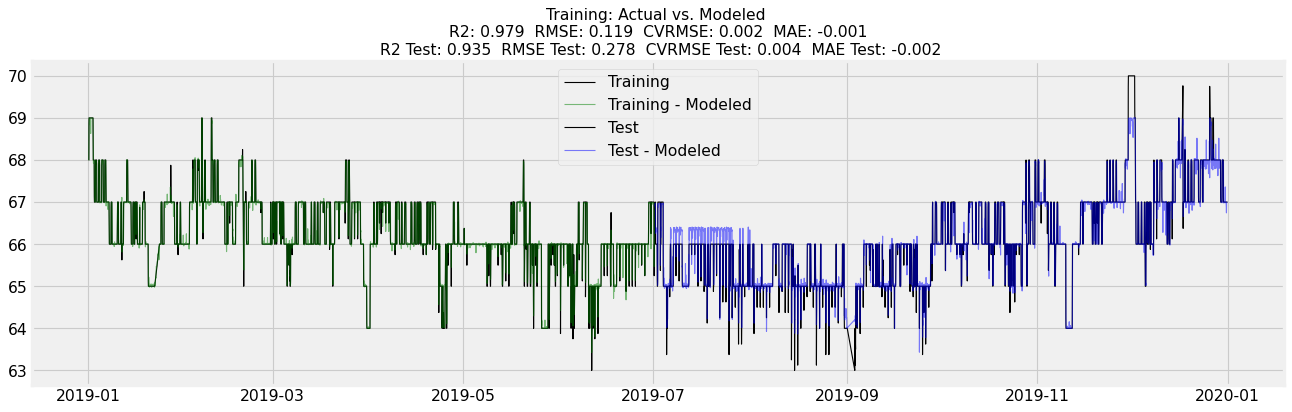

CPU times: user 1.52 s, sys: 56.1 ms, total: 1.57 s
Wall time: 1.61 s


In [123]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

mod_rf = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=mod_inputs['random_seed'],verbose = 1)

rf = create_model(data3, X, y, mod_rf, mod_inputs=mod_inputs)

## 'CHEMX.AHU.SF1N.Heating Valve Control Output'

In [124]:
tags = ['CHEMX.AHU.SF1N.Heating Valve Control Output', 'aiTIT4045']
start = '2020-01-01'
end = '2021-01-01'
interval = '1h'
calculation = 'summary'
summary_type = 'average'

In [125]:
data = pi.get_stream_by_point(tags=tags, start=start, end=end, interval=interval, calculation=calculation, _summary_type=summary_type)
#data.head()

12:36:09: Sending API request... Chunk 1 of 1
12:36:10: Response recieved for 2 tags! (1.03)


In [126]:
data2 = create_standard_multivariable_df(data)
#data2.head()

In [127]:
data3 = clean_data(data2, 'CHEMX.AHU.SF1N.Heating Valve Control Output')

In [128]:
y = data3.iloc[:,0]
X = data3.iloc[:,1:]

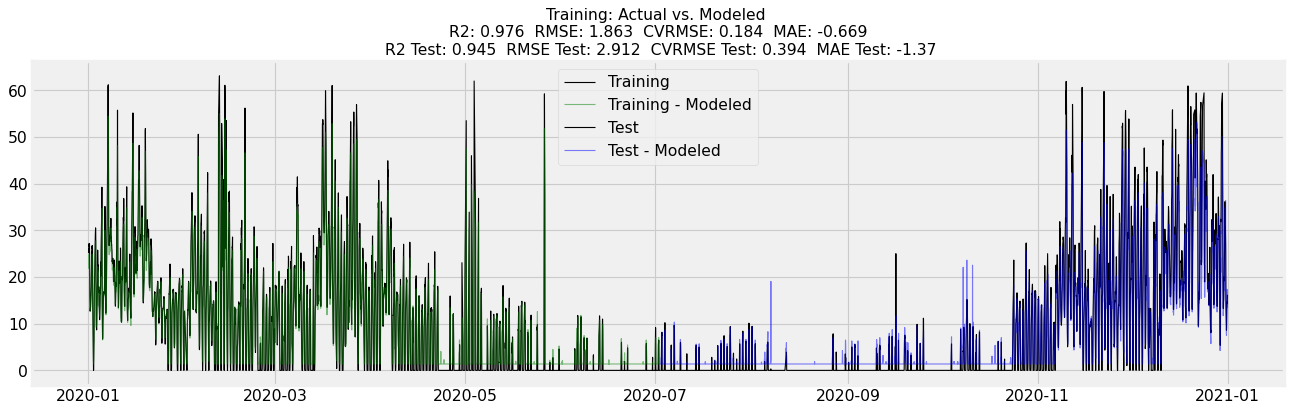

CPU times: user 5.31 s, sys: 53 ms, total: 5.37 s
Wall time: 7.33 s


In [129]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

gbr = create_gbr_model_hrs(data3, X, y, mod_inputs=mod_inputs)

In [130]:
gbr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 5,
 'max_leaf_nodes': 200,
 'max_depth': 10,
 'loss': 'ls',
 'learning_rate': 0.01,
 'criterion': 'friedman_mse'}

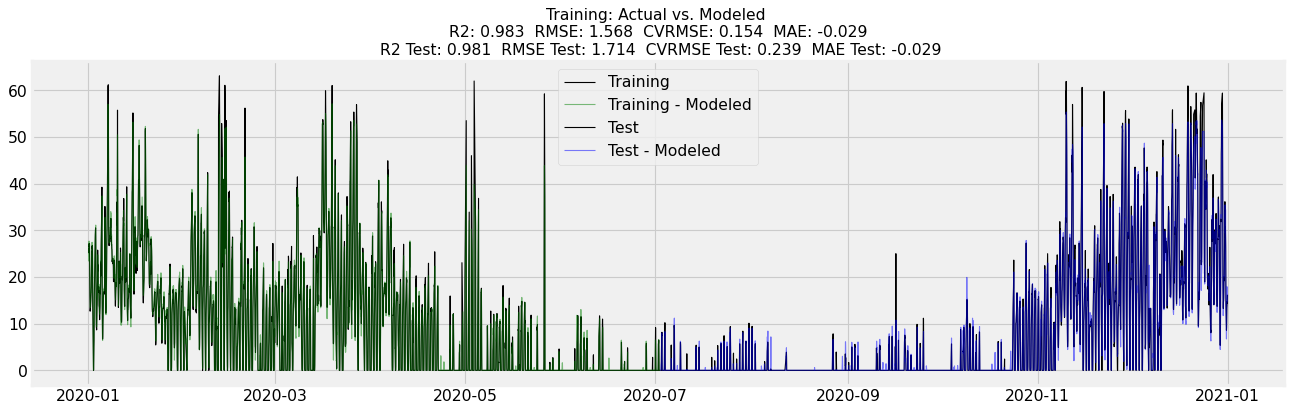

CPU times: user 3.7 s, sys: 45.1 ms, total: 3.74 s
Wall time: 9.09 s


In [131]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

rfr = create_rfr_model_hrs(data3, X, y, mod_inputs=mod_inputs)

In [132]:
rfr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 2,
 'max_leaf_nodes': 100,
 'max_depth': 10,
 'criterion': 'squared_error'}

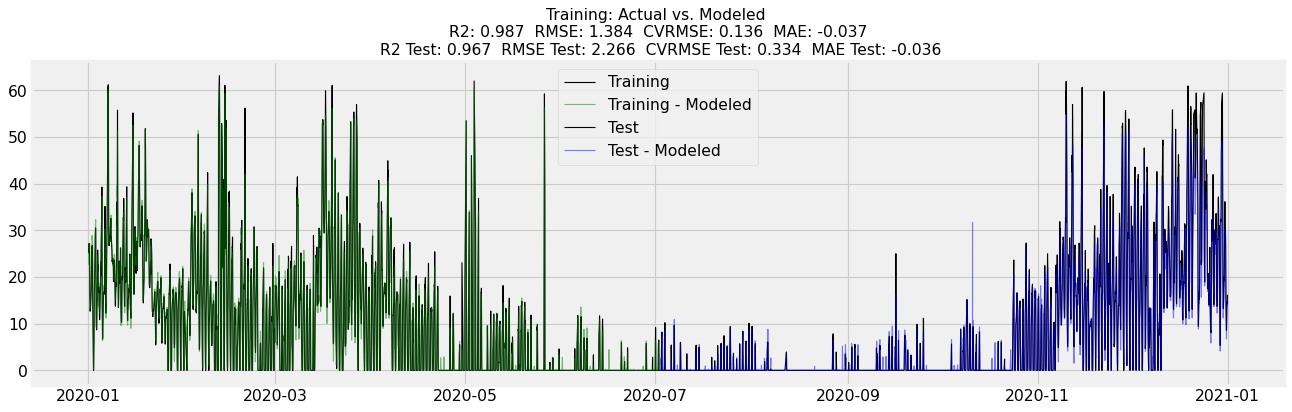

CPU times: user 3.09 s, sys: 49.1 ms, total: 3.13 s
Wall time: 7.39 s


In [133]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

etr = create_etr_model_hrs(data3, X, y, mod_inputs=mod_inputs)

In [134]:
etr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 2,
 'max_leaf_nodes': 100,
 'max_depth': 10,
 'criterion': 'squared_error'}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Training: Actual vs. Modeled 
 R2: 0.994  RMSE: 0.957  CVRMSE: 0.094  MAE: -0.003
Test: Actual vs. Modeled 
 R2: 0.968  RMSE: 2.232  CVRMSE: 0.332  MAE: -0.003


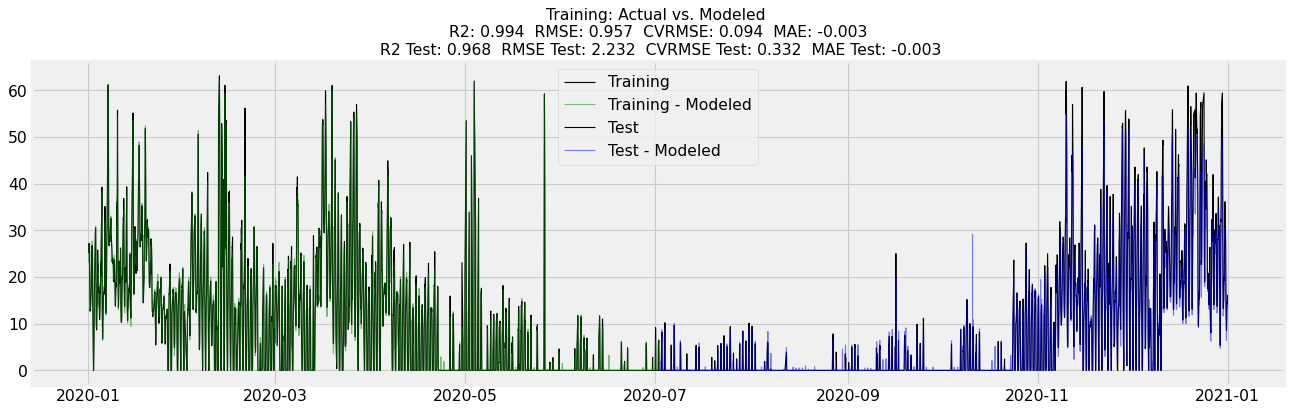

CPU times: user 1.52 s, sys: 44.7 ms, total: 1.56 s
Wall time: 1.64 s


In [135]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

mod_et = ExtraTreesRegressor(max_depth=10, n_estimators=100, random_state=mod_inputs['random_seed'],verbose = 1)

et = create_model(data2, X, y, mod_et, mod_inputs=mod_inputs)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


Training: Actual vs. Modeled 
 R2: 0.988  RMSE: 1.314  CVRMSE: 0.13  MAE: -0.0
Test: Actual vs. Modeled 
 R2: 0.981  RMSE: 1.729  CVRMSE: 0.243  MAE: -0.0


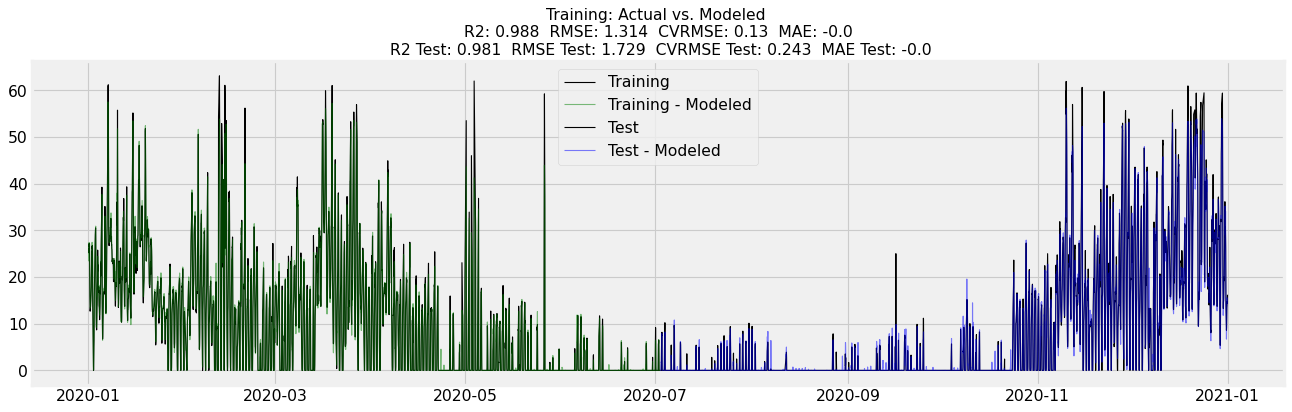

CPU times: user 1.84 s, sys: 69.8 ms, total: 1.91 s
Wall time: 2.39 s


In [136]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

mod_rf = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=mod_inputs['random_seed'],verbose = 1)

rf = create_model(data3, X, y, mod_rf, mod_inputs=mod_inputs)

## 'CHEMX.AHU.SF1S.Heating Valve Control Output'

In [137]:
tags = [ 'CHEMX.AHU.SF1S.Heating Valve Control Output', 'aiTIT4045']
start = '2019-01-01'
end = '2020-01-01'
interval = '1h'
calculation = 'summary'
summary_type = 'average'

In [138]:
data = pi.get_stream_by_point(tags=tags, start=start, end=end, interval=interval, calculation=calculation, _summary_type=summary_type)
#data.head()

12:37:28: Sending API request... Chunk 1 of 1
12:37:30: Response recieved for 2 tags! (1.84)


In [139]:
data2 = create_standard_multivariable_df(data)
#data2.head()

In [140]:
data3 = clean_data(data2,  'CHEMX.AHU.SF1S.Heating Valve Control Output')

In [141]:
y = data3.iloc[:,0]
X = data3.iloc[:,1:]

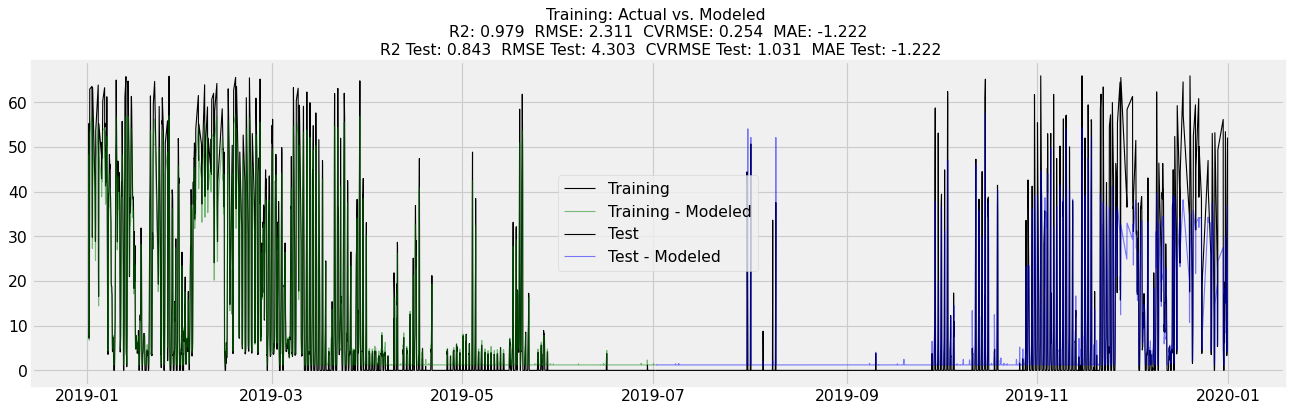

CPU times: user 4.55 s, sys: 60.9 ms, total: 4.61 s
Wall time: 6.26 s


In [142]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

gbr = create_gbr_model_hrs(data3, X, y, mod_inputs=mod_inputs)

In [143]:
gbr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 5,
 'max_leaf_nodes': 200,
 'max_depth': 10,
 'loss': 'ls',
 'learning_rate': 0.01,
 'criterion': 'friedman_mse'}

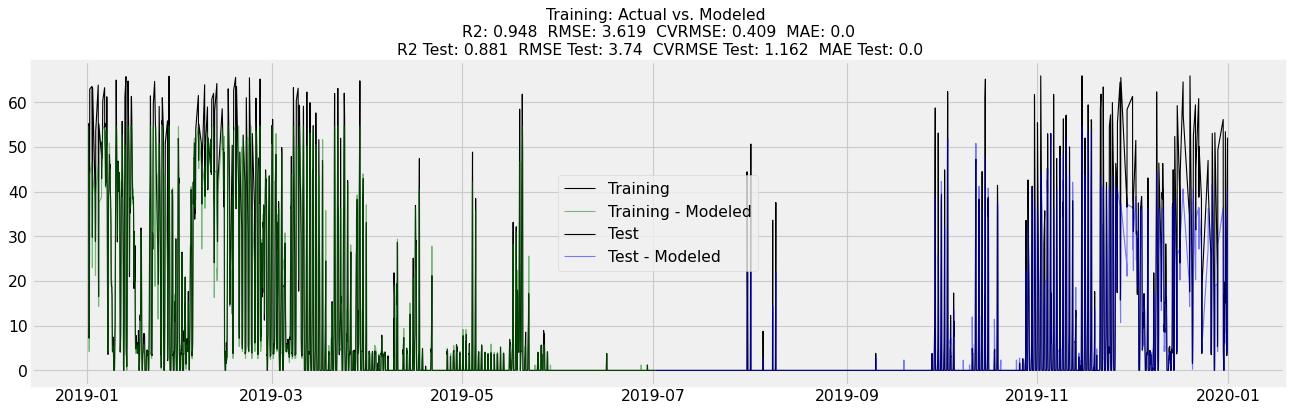

CPU times: user 2min 26s, sys: 342 ms, total: 2min 27s
Wall time: 2min 34s


In [144]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

rfr = create_rfr_model_hrs(data3, X, y, mod_inputs=mod_inputs)

In [146]:
rfr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 2,
 'max_leaf_nodes': 10,
 'max_depth': 50,
 'criterion': 'absolute_error'}

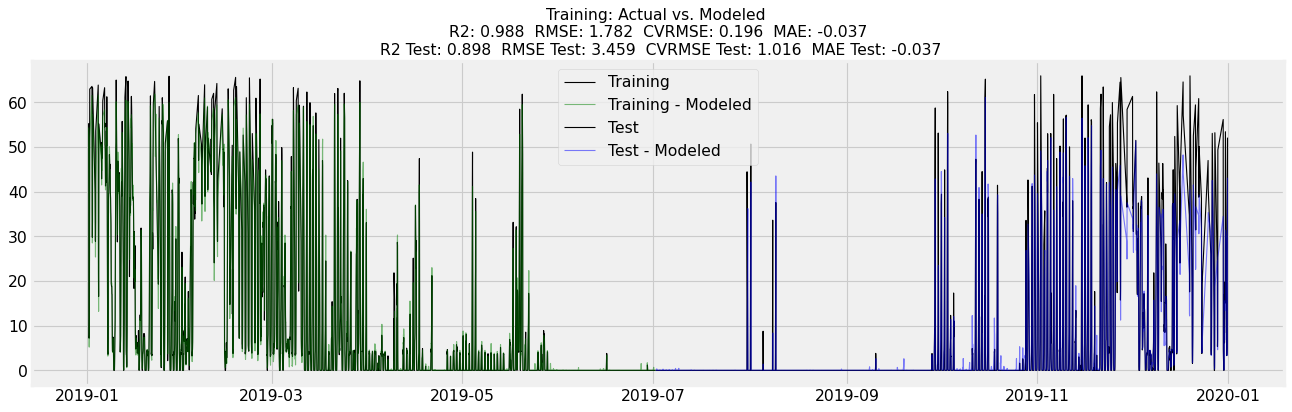

CPU times: user 2.69 s, sys: 49.7 ms, total: 2.73 s
Wall time: 7.1 s


In [147]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

etr= create_etr_model_hrs(data3, X, y, mod_inputs=mod_inputs)

In [148]:
etr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 2,
 'max_leaf_nodes': 100,
 'max_depth': 10,
 'criterion': 'squared_error'}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Training: Actual vs. Modeled 
 R2: 0.994  RMSE: 1.211  CVRMSE: 0.133  MAE: -0.0
Test: Actual vs. Modeled 
 R2: 0.897  RMSE: 3.481  CVRMSE: 1.037  MAE: -0.0


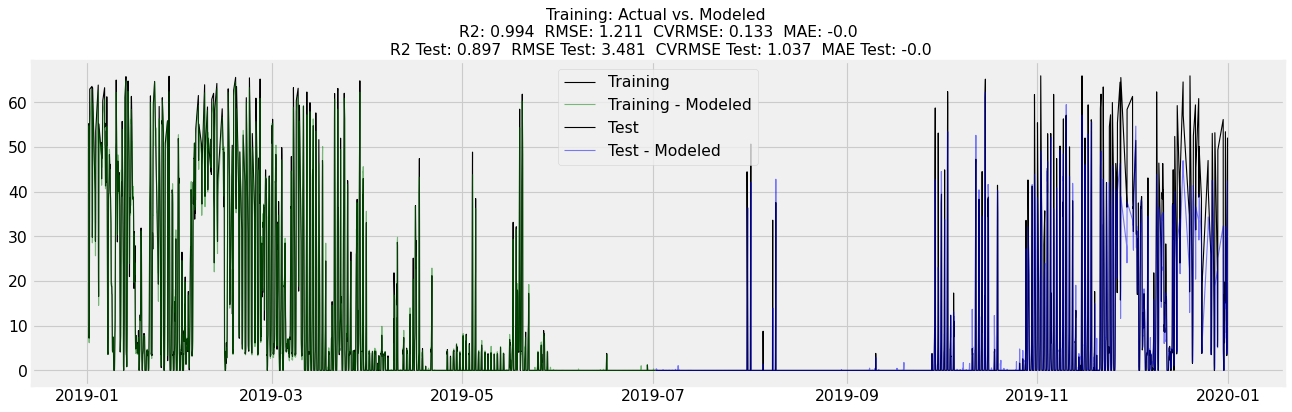

CPU times: user 1.09 s, sys: 40.2 ms, total: 1.13 s
Wall time: 1.17 s


In [149]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

mod_et = ExtraTreesRegressor(max_depth=10, n_estimators=100, random_state=mod_inputs['random_seed'],verbose = 1)

et = create_model(data2, X, y, mod_et, mod_inputs=mod_inputs)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Training: Actual vs. Modeled 
 R2: 0.992  RMSE: 1.441  CVRMSE: 0.159  MAE: -0.0
Test: Actual vs. Modeled 
 R2: 0.881  RMSE: 3.746  CVRMSE: 1.113  MAE: -0.0


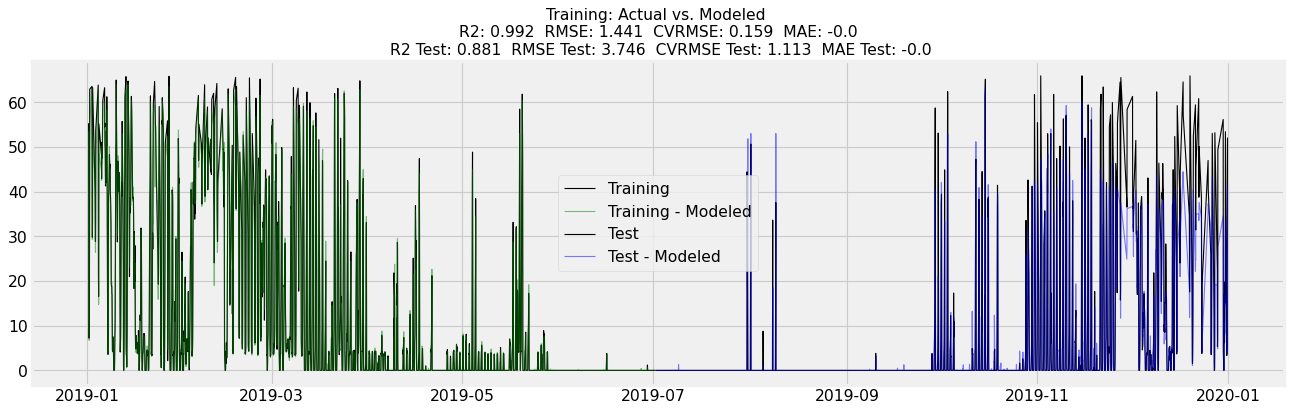

CPU times: user 1.35 s, sys: 44.3 ms, total: 1.4 s
Wall time: 1.44 s


In [150]:
%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

mod_rf = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=mod_inputs['random_seed'],verbose = 1)

rf = create_model(data3, X, y, mod_rf, mod_inputs=mod_inputs)